In [1]:
# We load the competition data

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import warnings
warnings.filterwarnings("ignore")

/kaggle/input/playground-series-s5e7/sample_submission.csv
/kaggle/input/playground-series-s5e7/train.csv
/kaggle/input/playground-series-s5e7/test.csv


# Packages

In [2]:
!pip install autoviz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.5/67.5 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 170.3/170.3 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 69.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 255.9/255.9 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 35.1 MB/s eta 0:00:00
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.7.2
    Uninstalling matplotlib-3.7.2:
      Successfully uninstalled matplotlib-3.7.2
  Attempting uninstall: xgboost
    Found existing installation: xgboost 2.0.3
    Uninstalling xgboost-2.0.3:
      Successfully uninstalled xgboost-2.0.3
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.12.2
    Uninstalling seaborn-0.12.2:
      Successfully uninstalled seaborn-0.12.2
ERROR: pip's dependency resolver does not cu

# Libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import shap

from autoviz.AutoViz_Class import AutoViz_Class
from sklearn.impute import KNNImputer
from sklearn.preprocessing import (
    LabelEncoder,    
    OneHotEncoder,
    RobustScaler
)
from sklearn.model_selection import (
    train_test_split, 
    StratifiedKFold, 
    RandomizedSearchCV
)
from sklearn.metrics import (
    confusion_matrix, 
    classification_report, 
    f1_score, 
    accuracy_score,
)
from sklearn.feature_selection import mutual_info_classif
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.ensemble import BaggingClassifier

Imported v0.1.905. Please call AutoViz in this sequence:
    AV = AutoViz_Class()
    %matplotlib inline
    dfte = AV.AutoViz(filename, sep=',', depVar='', dfte=None, header=0, verbose=1, lowess=False,
               chart_format='svg',max_rows_analyzed=150000,max_cols_analyzed=30, save_plot_dir=None)


# Predict the Introverts from the Extroverts

### Playground Series - Season 5, Episode 7

### Your Goal: 

Your objective is to predict whether a person is an Introvert or Extrovert, given their social behavior and personality traits.

### Evaluation:

Submissions are evaluated using Accuracy Score between the predicted value and the observed target.

### Submission File:

For each id in the test set, you must predict the target Personality. The file should contain a header and have the following format:

    id,Personality
    18524,Extrovert
    18525,Introvert
    18526,Introvert
    etc.

### Timeline:

- Start Date - June 30, 2025
- Entry Deadline - Same as the Final Submission Deadline
- Team Merger Deadline - Same as the Final Submission Deadline
- Final Submission Deadline - July 31, 2025

All deadlines are at 11:59 PM UTC on the corresponding day unless otherwise noted. The competition organizers reserve the right to update the contest timeline if they deem it necessary.

# Initial analysis

We'll begin by conducting a basic initial analysis to familiarize ourselves with the competition data and understand the variables and samples we have available.

In [4]:
# We load the data

personality_train = pd.read_csv("/kaggle/input/playground-series-s5e7/train.csv", index_col="id")

In [5]:
personality_train.shape

(18524, 8)

In [6]:
personality_train.head()

,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
id,,,,,,,,
0,0.0,No,6.0,4.0,No,15.0,5.0,Extrovert
1,1.0,No,7.0,3.0,No,10.0,8.0,Extrovert
2,6.0,Yes,1.0,0.0,NaN,3.0,0.0,Introvert
3,3.0,No,7.0,3.0,No,11.0,5.0,Extrovert
4,1.0,No,4.0,4.0,No,13.0,NaN,Extrovert


In [7]:
personality_train.describe().style.background_gradient(cmap='Greens')

,Time_spent_Alone,Social_event_attendance,Going_outside,Friends_circle_size,Post_frequency
count,17334.000000,17344.000000,17058.000000,17470.000000,17260.000000
mean,3.137764,5.265106,4.044319,7.996737,4.982097
std,3.003786,2.753359,2.062580,4.223484,2.879139
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,3.000000,3.000000,5.000000,3.000000
50%,2.000000,5.000000,4.000000,8.000000,5.000000
75%,4.000000,8.000000,6.000000,12.000000,7.000000
max,11.000000,10.000000,7.000000,15.000000,10.000000


In [8]:
personality_train.describe(exclude=np.number).T

,count,unique,top,freq
Stage_fear,16631,2,No,12609
Drained_after_socializing,17375,2,No,13313
Personality,18524,2,Extrovert,13699


In [9]:
personality_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18524 entries, 0 to 18523
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Time_spent_Alone           17334 non-null  float64
 1   Stage_fear                 16631 non-null  object 
 2   Social_event_attendance    17344 non-null  float64
 3   Going_outside              17058 non-null  float64
 4   Drained_after_socializing  17375 non-null  object 
 5   Friends_circle_size        17470 non-null  float64
 6   Post_frequency             17260 non-null  float64
 7   Personality                18524 non-null  object 
dtypes: float64(5), object(3)
memory usage: 1.3+ MB


We are faced with a binary classification problem. The data includes our target variable, five numerical variables, and two categoricals. The numerical variables are within the same value range, and the categorical variables are binary. We don't have a large number of features, which is important for analyzing feature engineering opportunities, and we also have few samples in the training set. We will begin our exploratory data analysis.

# EDA

We will conduct our exploratory data analysis. To do this, we will use an auto-EDA tool, replacing a more personalized analysis, creating some useful functions and evaluating each variable individually. We will use this approach to test different EDA methods. To try different approaches, if you'd like, I've shared two links. One where I apply two different auto-EDA methods, and the other, more personalized, with useful functions.

- https://www.kaggle.com/code/les1781/calorie-expenditure-predic-playground-series-s5-e5
- https://www.kaggle.com/code/les1781/optimal-fertilizer-predict-playground-series-s5-e6

For this Playground, I have chosen the 'AutoViz' tool. It's an automated data visualization tool that allows you to generate charts quickly and easily and can handle data sets of any size. It can automatically identify data types and relationships, detect and help resolve data quality issues, making data exploration and analysis easier.

- https://github.com/AutoViML/AutoViz
- https://pypi.org/project/autoviz/

Shape of your Data Set loaded: (18524, 8)
#######################################################################################
######################## C L A S S I F Y I N G  V A R I A B L E S  ####################
#######################################################################################
Classifying variables in data set...
    Number of Numeric Columns =  5
    Number of Integer-Categorical Columns =  0
    Number of String-Categorical Columns =  0
    Number of Factor-Categorical Columns =  0
    Number of String-Boolean Columns =  2
    Number of Numeric-Boolean Columns =  0
    Number of Discrete String Columns =  0
    Number of NLP String Columns =  0
    Number of Date Time Columns =  0
    Number of ID Columns =  0
    Number of Columns to Delete =  0
    7 Predictors classified...
        No variables removed since no ID or low-information variables found in data set

################ Binary_Classification problem #####################
To fix these data qualit

,Data Type,Missing Values%,Unique Values%,Minimum Value,Maximum Value,DQ Issue
Time_spent_Alone,float64,6.424098,NA,0.000000,11.000000,"1190 missing values. Impute them with mean, median, mode, or a constant value such as 123., Column has 1653 outliers greater than upper bound (8.50) or lower than lower bound(-3.50). Cap them or remove them."
Stage_fear,object,10.219175,0,,,"1893 missing values. Impute them with mean, median, mode, or a constant value such as 123., Mixed dtypes: has 2 different data types: object, float,"
Social_event_attendance,float64,6.370114,NA,0.000000,10.000000,"1180 missing values. Impute them with mean, median, mode, or a constant value such as 123."
Going_outside,float64,7.914057,NA,0.000000,7.000000,"1466 missing values. Impute them with mean, median, mode, or a constant value such as 123."
Drained_after_socializing,object,6.202764,0,,,"1149 missing values. Impute them with mean, median, mode, or a constant value such as 123., Mixed dtypes: has 2 different data types: object, float,"
Friends_circle_size,float64,5.689916,NA,0.000000,15.000000,"1054 missing values. Impute them with mean, median, mode, or a constant value such as 123."
Post_frequency,float64,6.823580,NA,0.000000,10.000000,"1264 missing values. Impute them with mean, median, mode, or a constant value such as 123."
Personality,object,0.000000,0,,,Target column


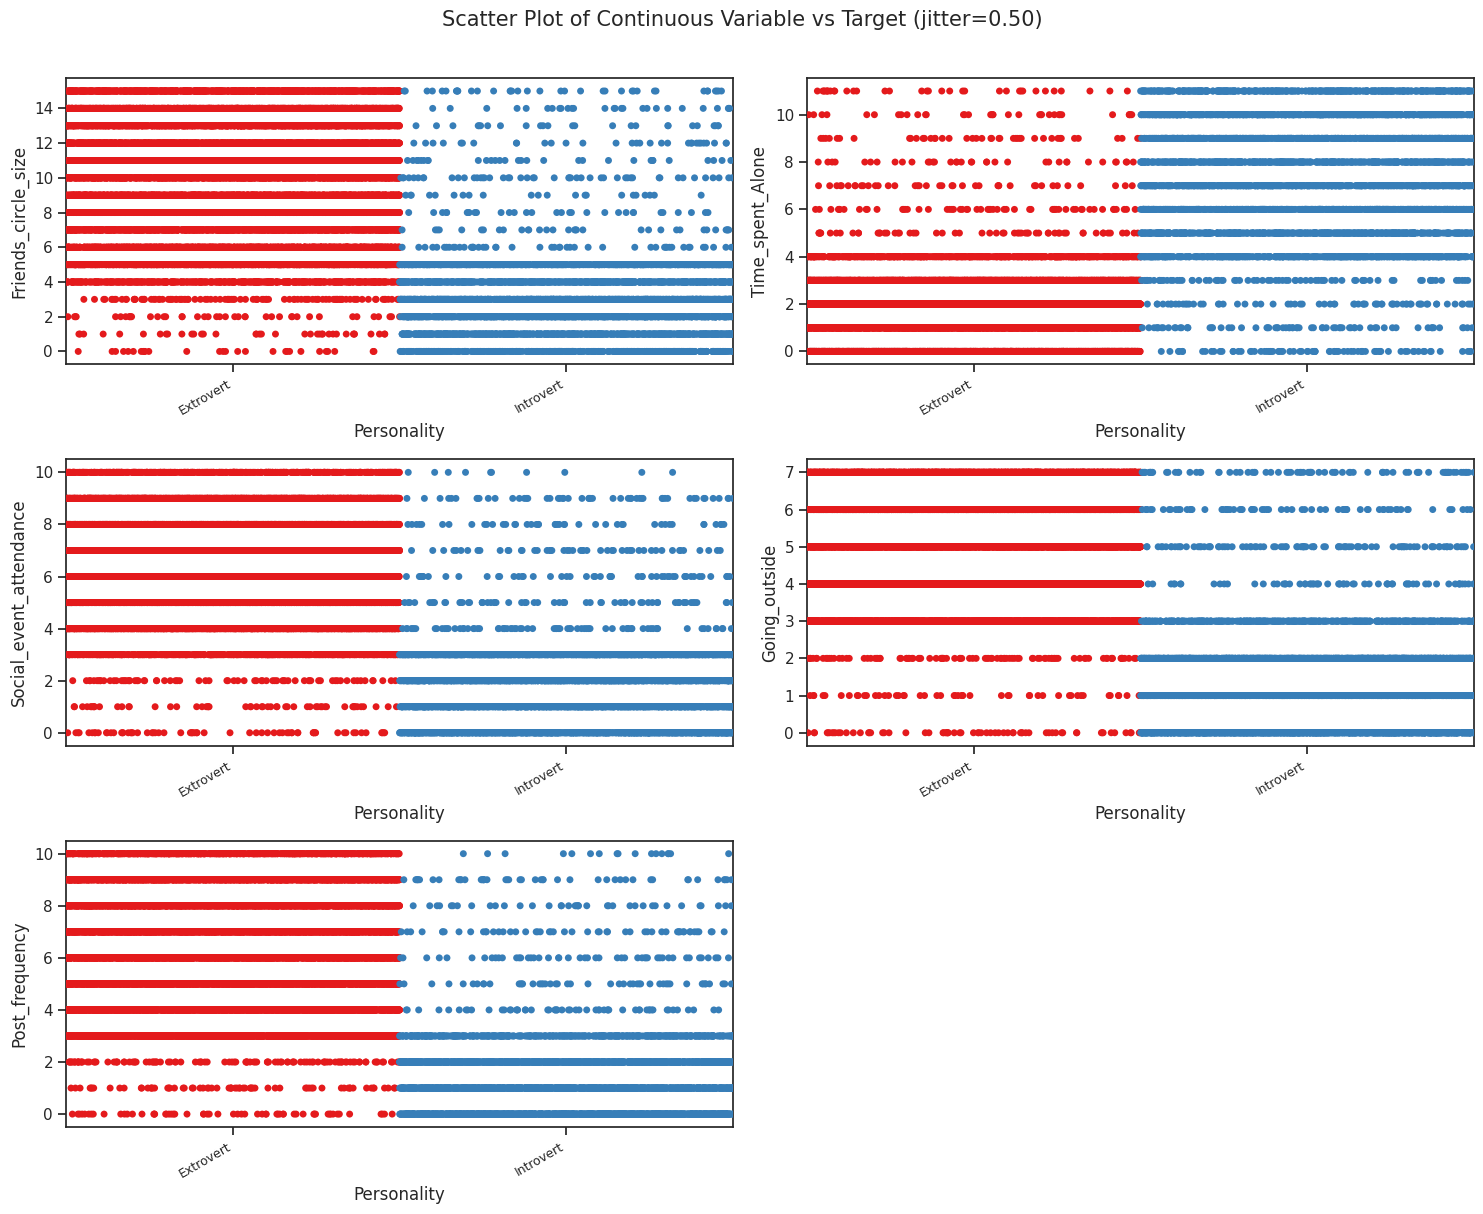

Total Number of Scatter Plots = 15


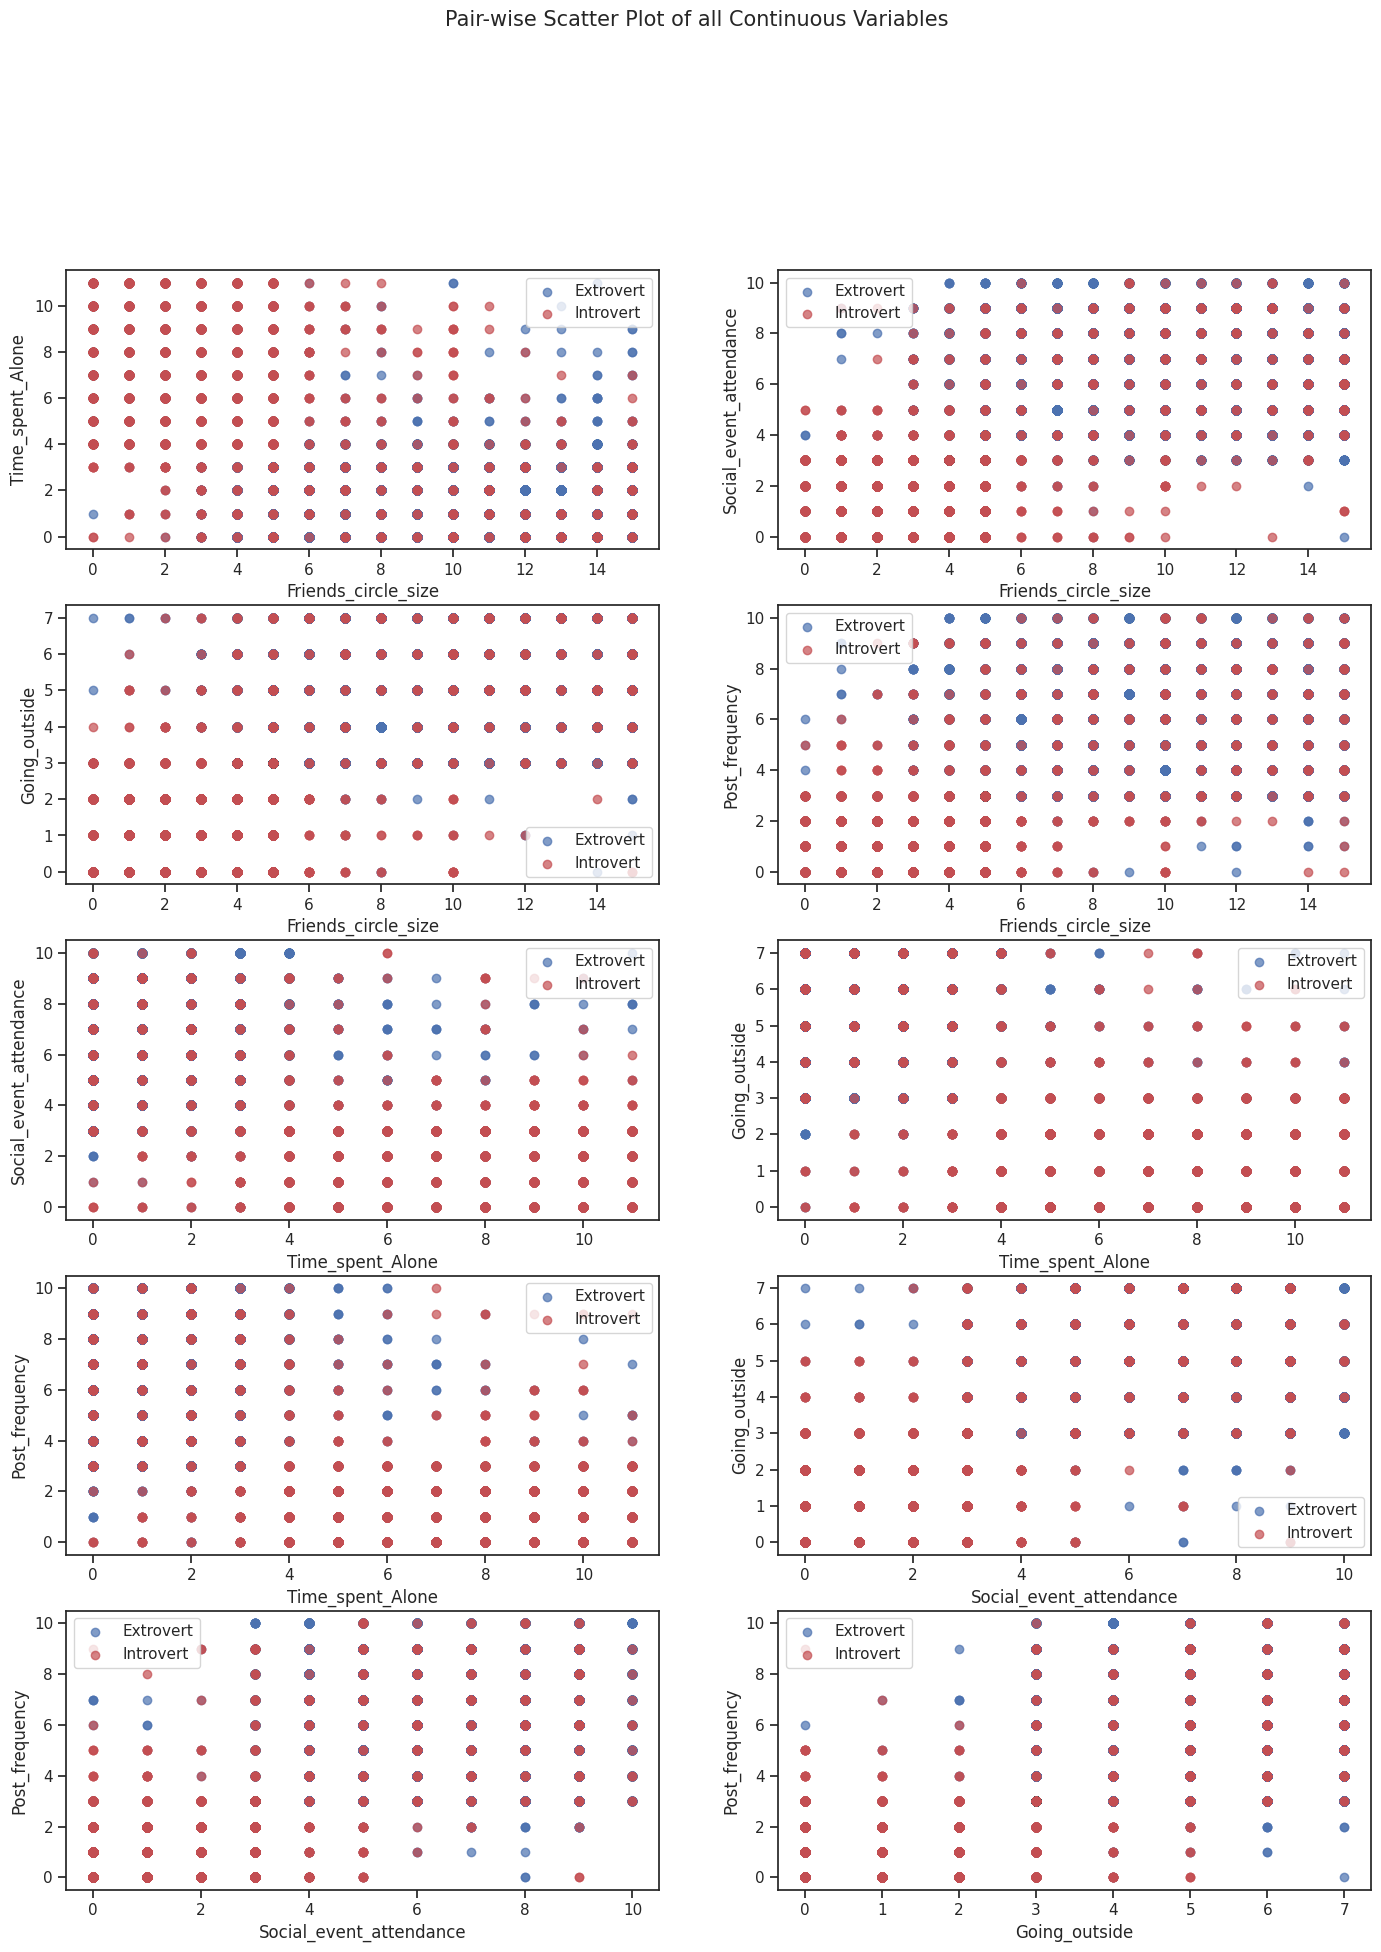

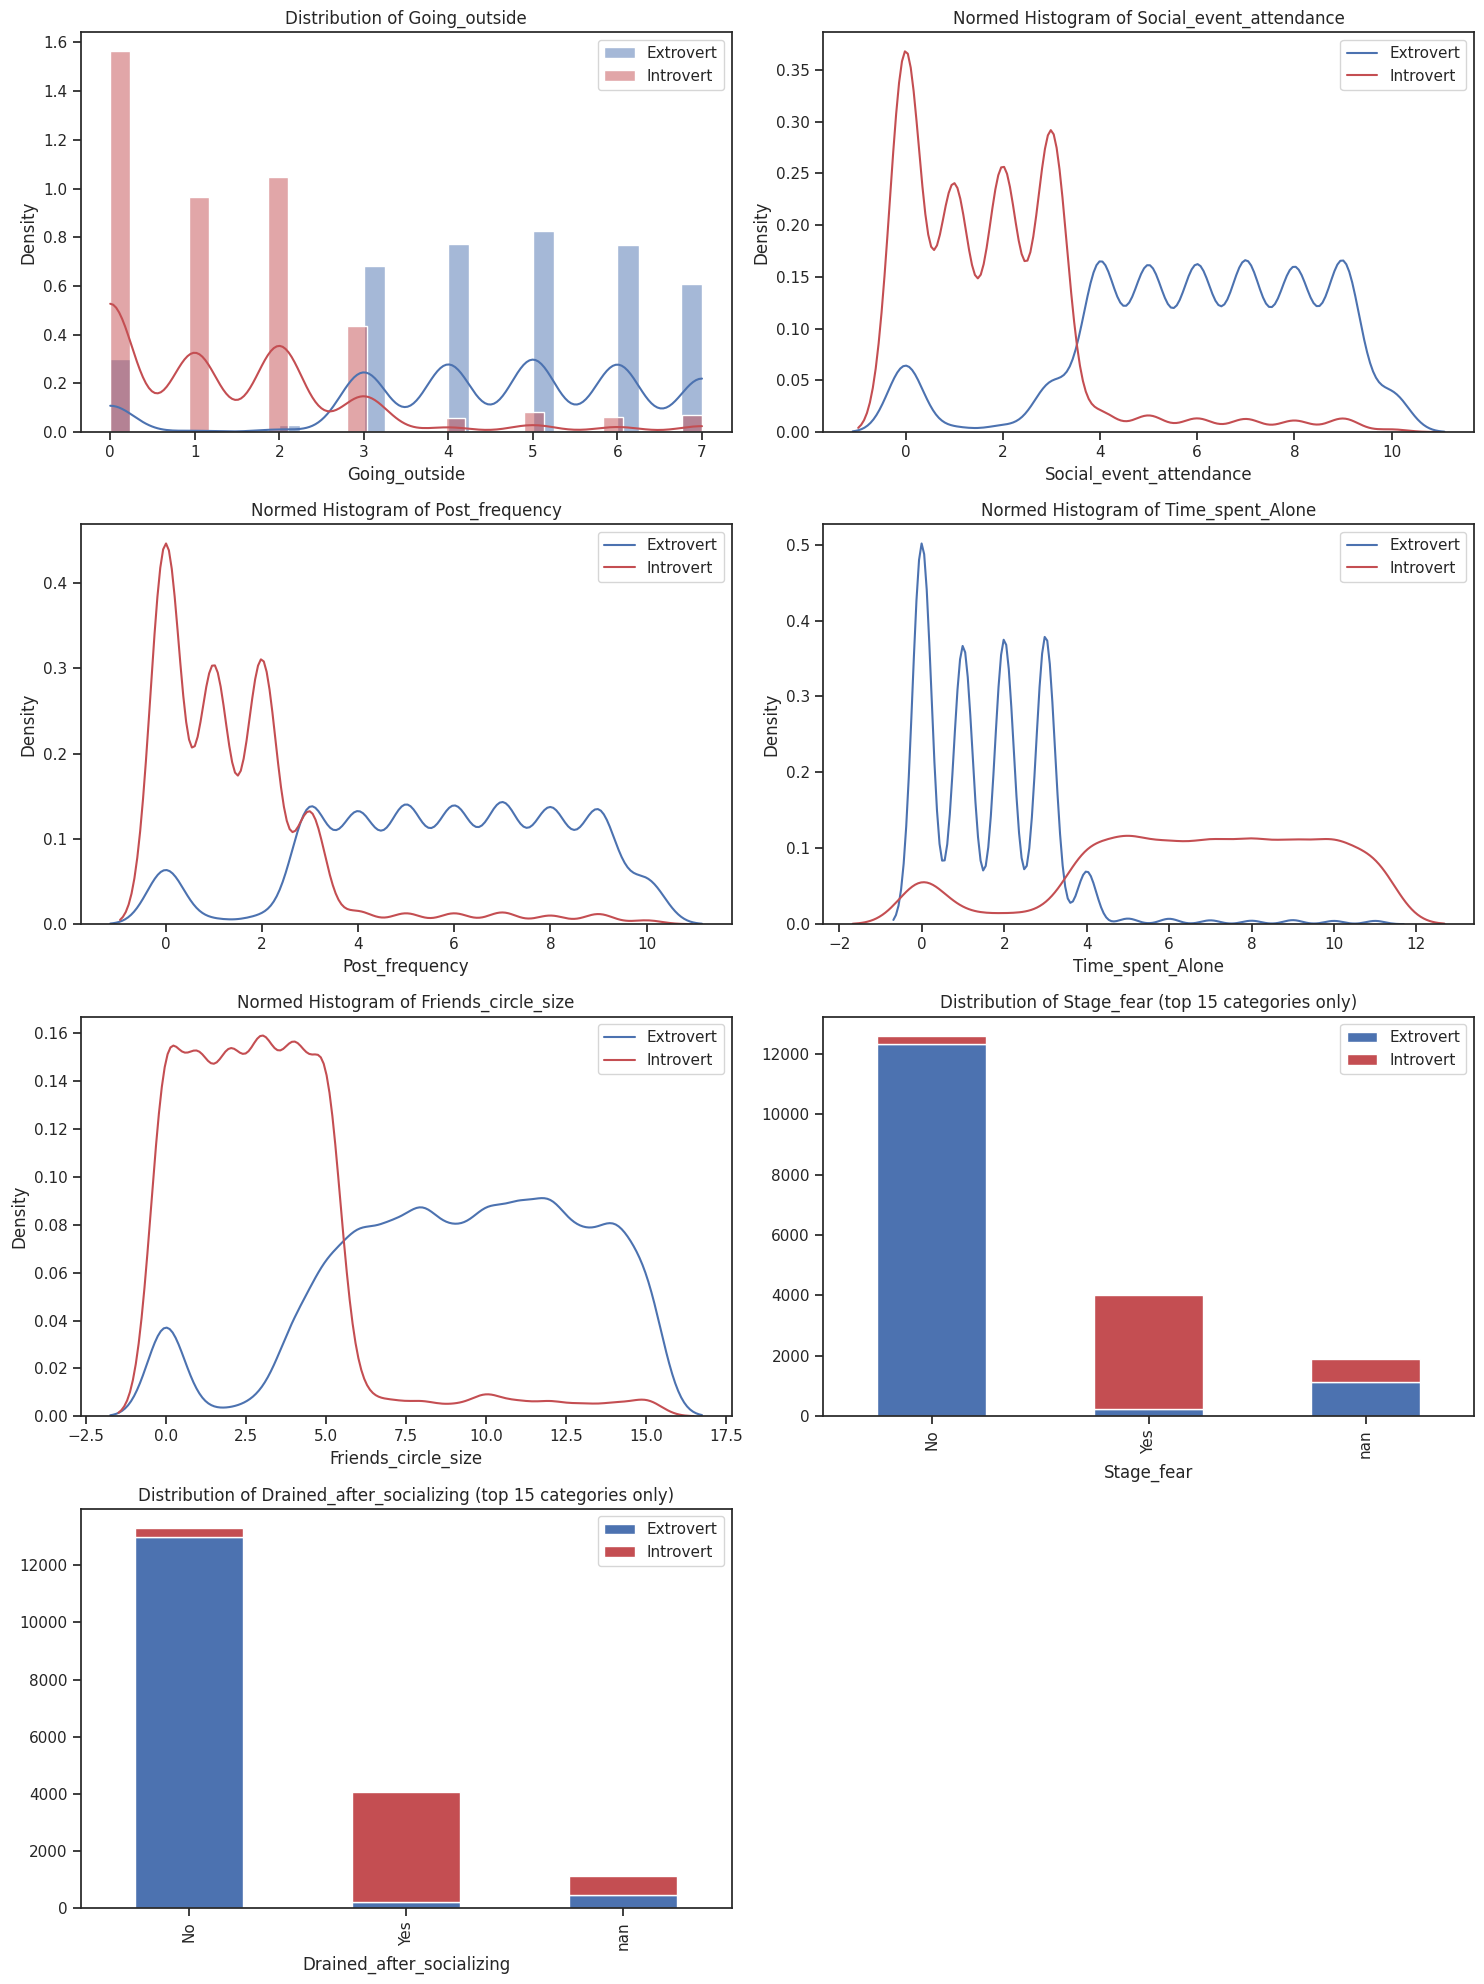

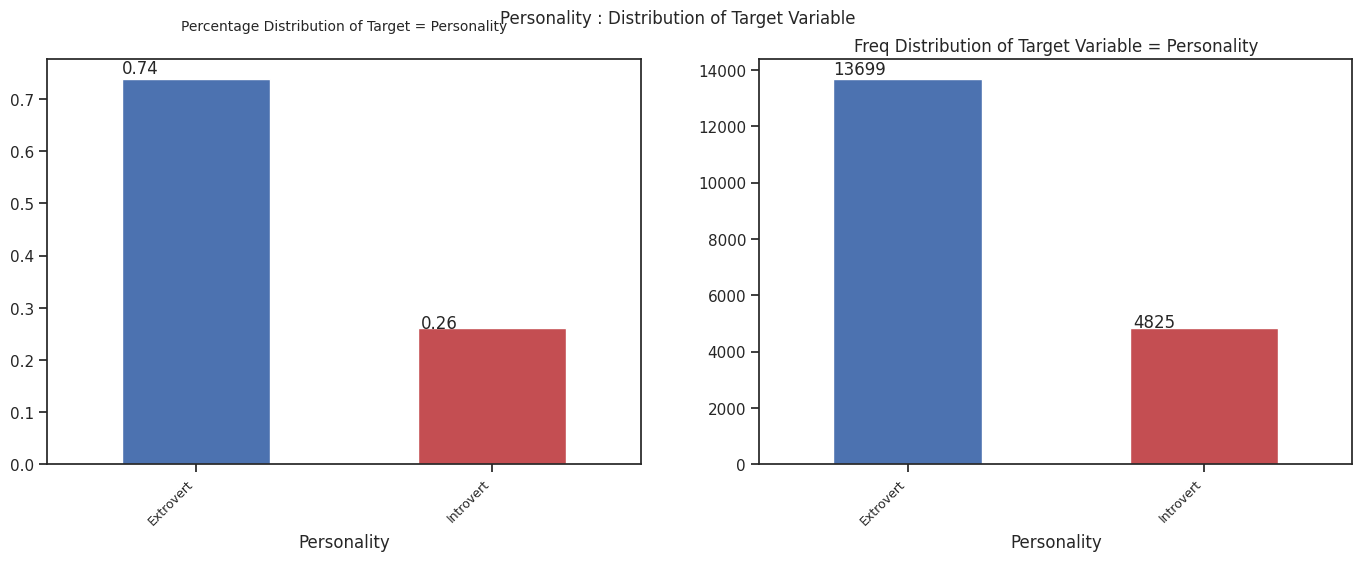

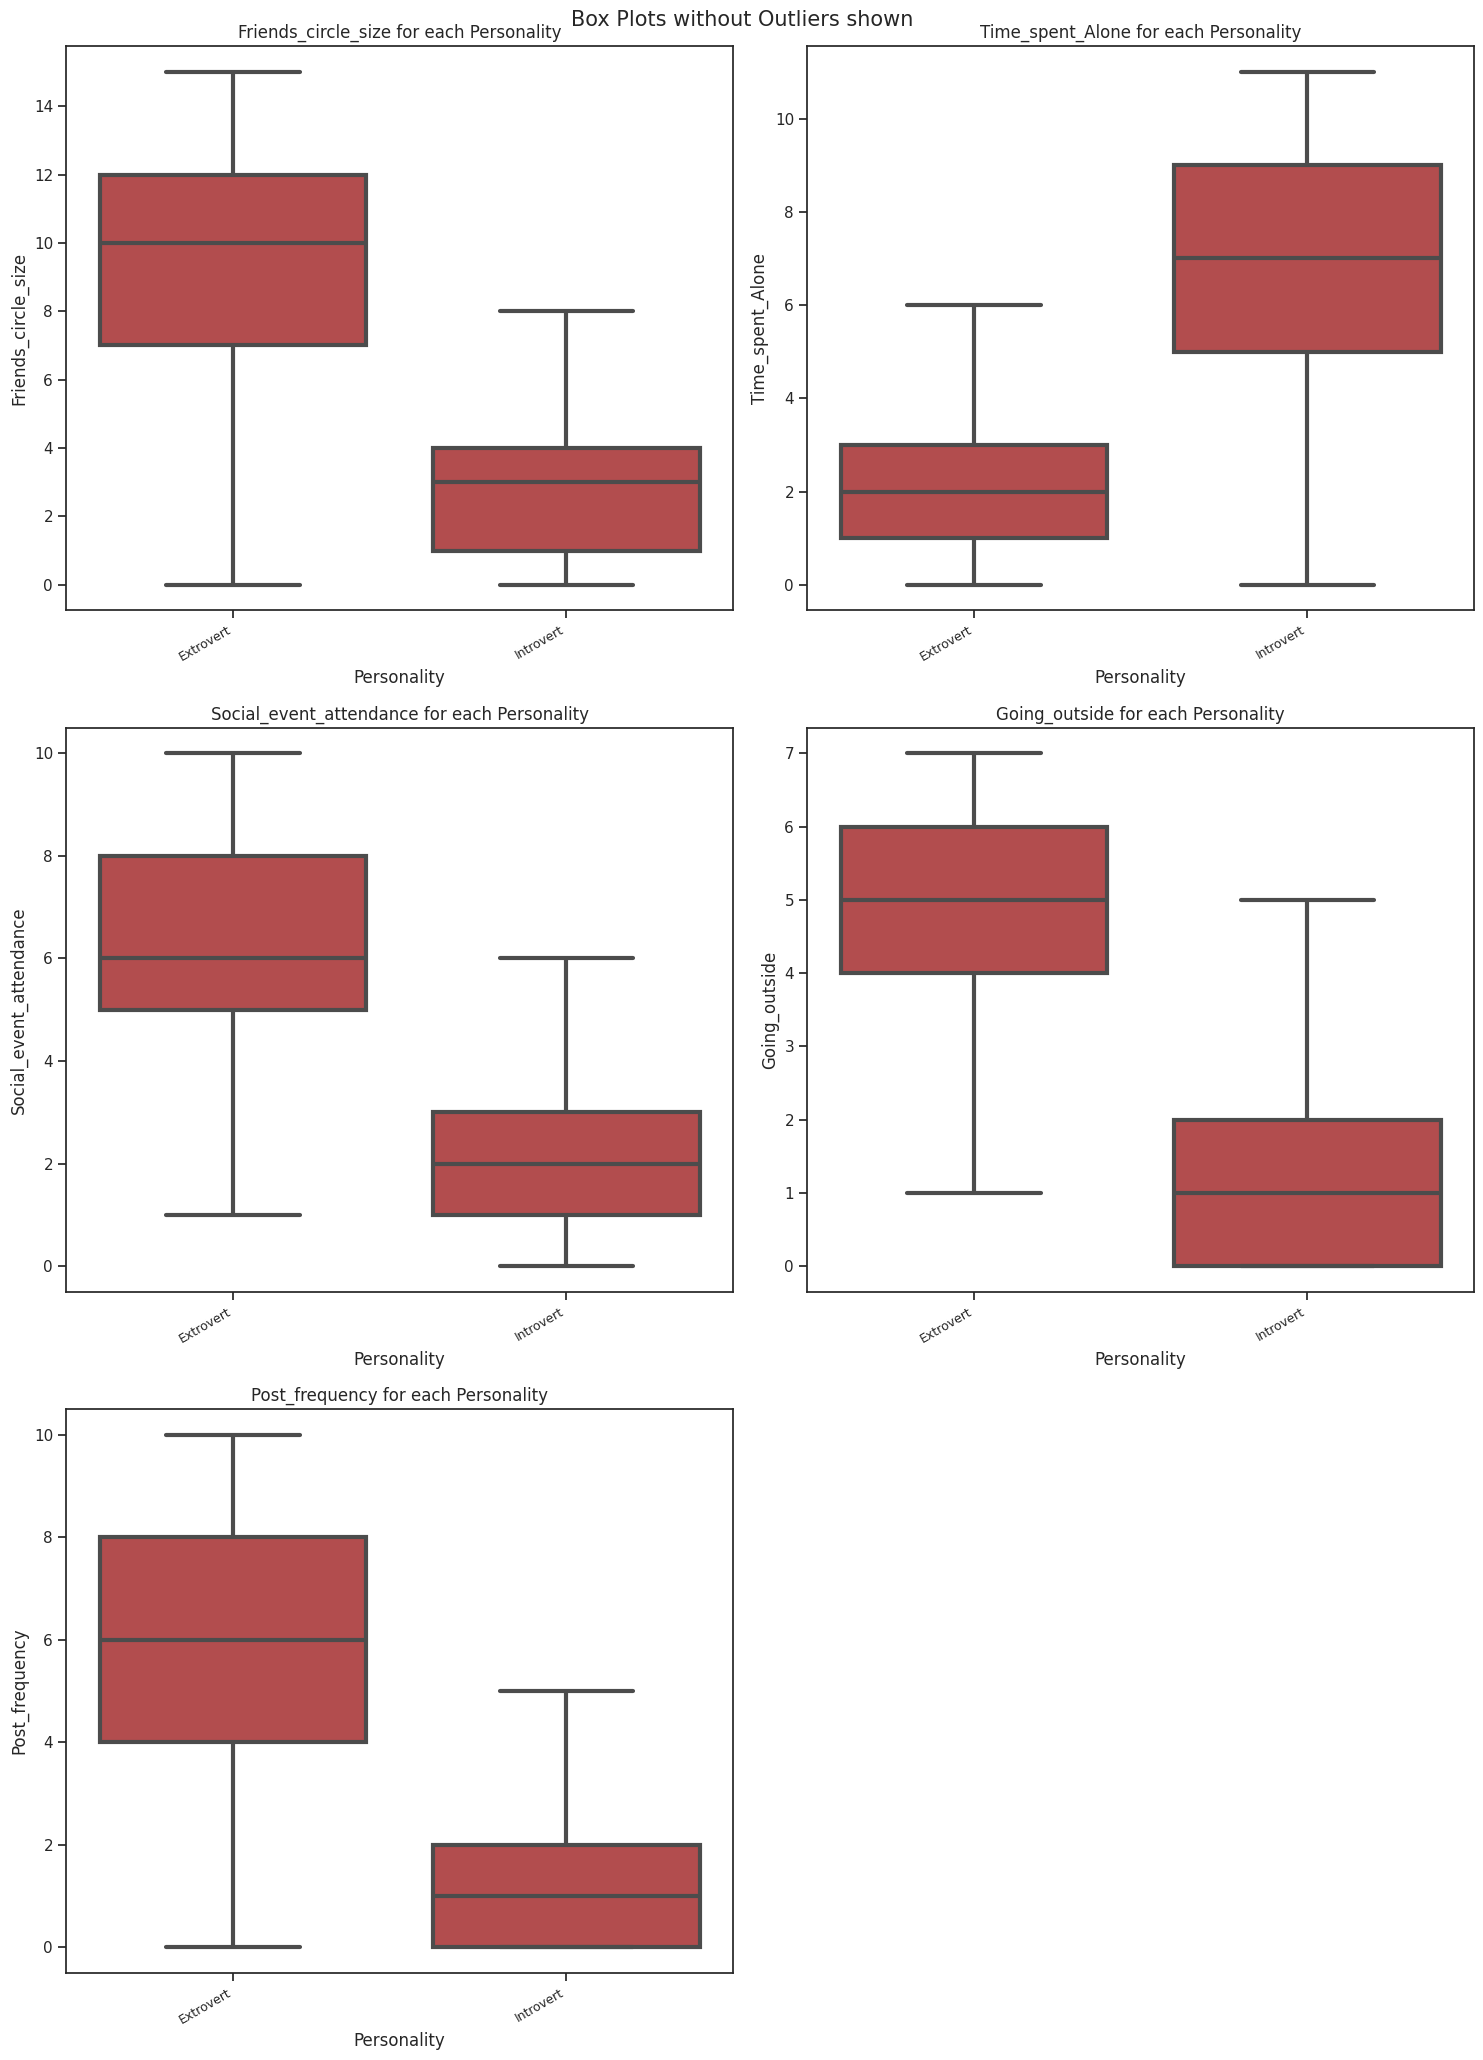

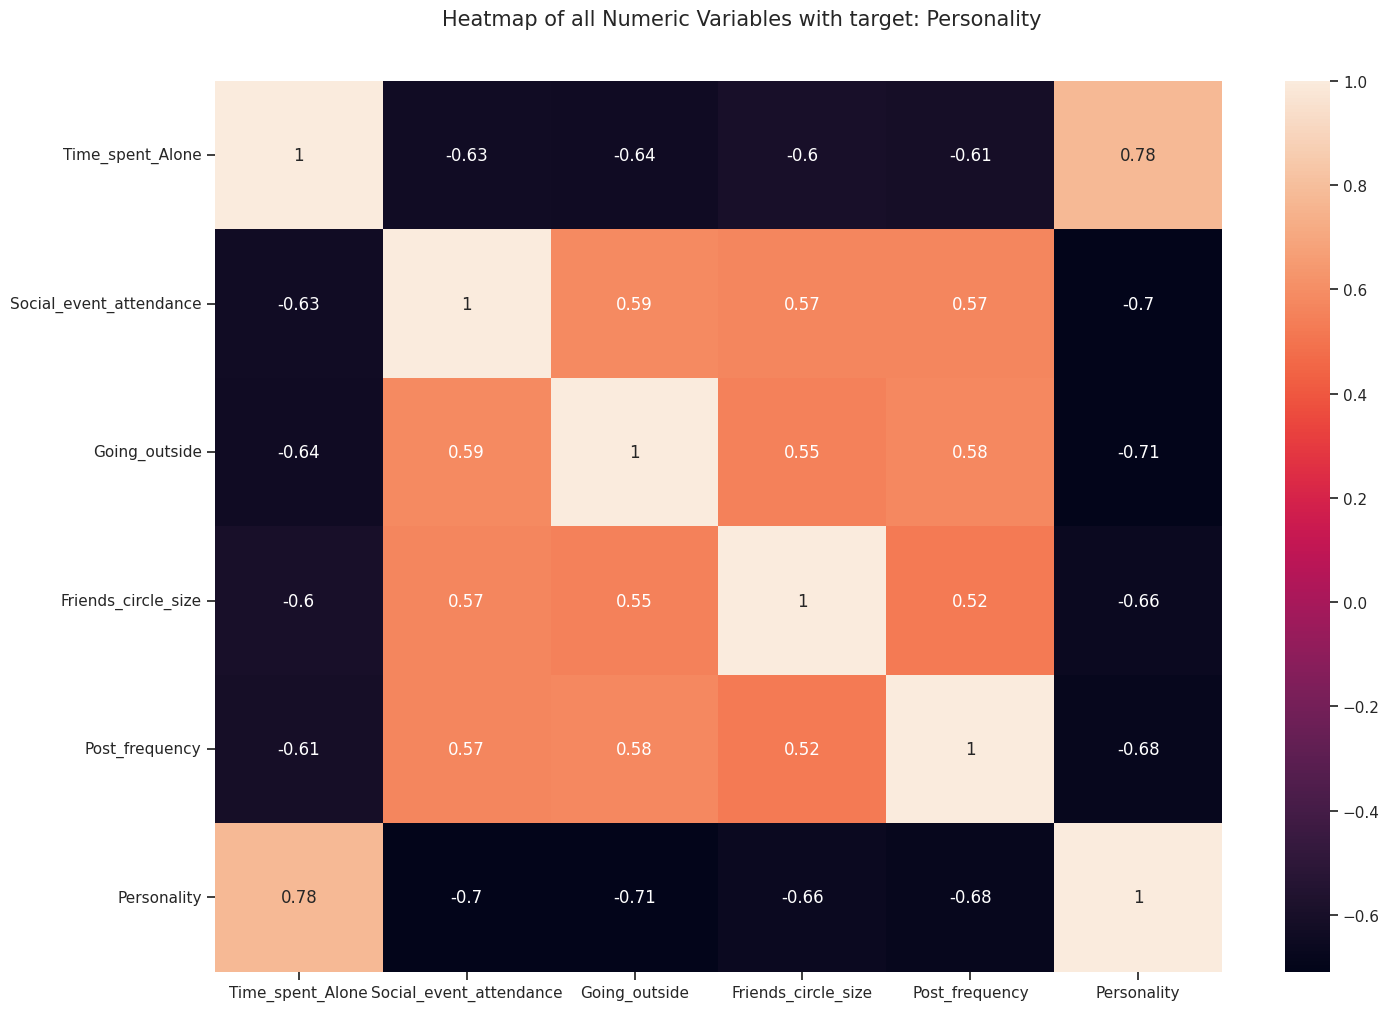

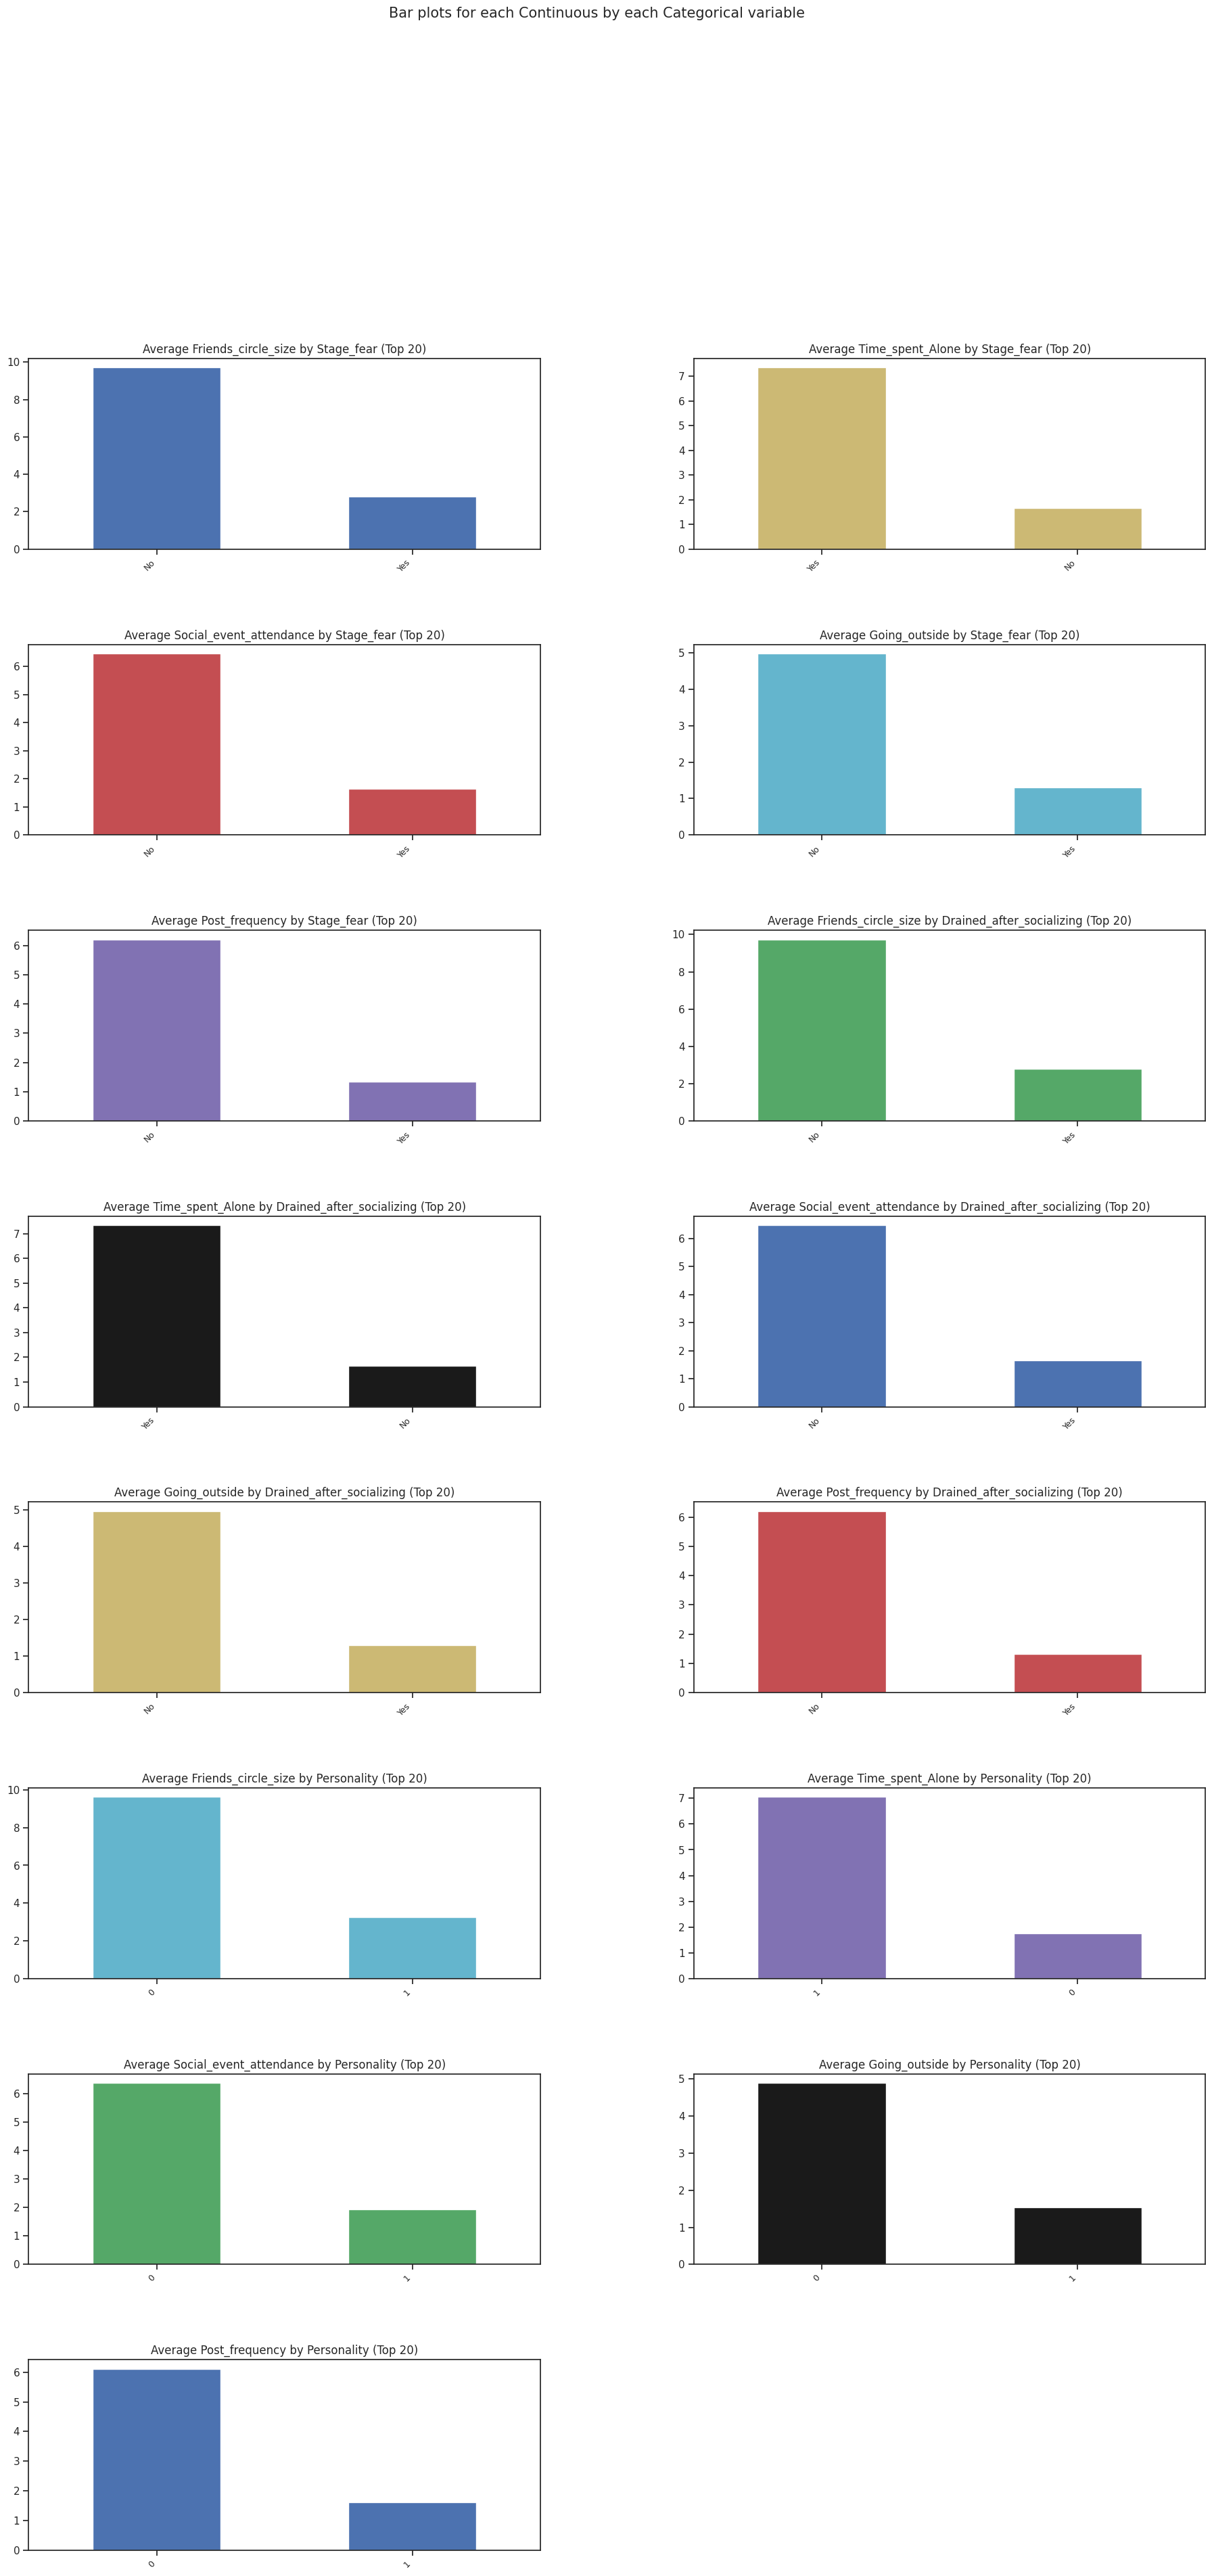

All Plots done
Time to run AutoViz = 21 seconds 

 ###################### AUTO VISUALIZATION Completed ########################


,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
id,,,,,,,,
0,0.0,No,6.0,4.0,No,15.0,5.0,0
1,1.0,No,7.0,3.0,No,10.0,8.0,0
2,6.0,Yes,1.0,0.0,NaN,3.0,0.0,1
3,3.0,No,7.0,3.0,No,11.0,5.0,0
4,1.0,No,4.0,4.0,No,13.0,NaN,0
...,...,...,...,...,...,...,...,...
18519,3.0,No,7.0,3.0,No,9.0,7.0,0
18520,1.0,NaN,6.0,7.0,No,6.0,5.0,0
18521,7.0,Yes,1.0,1.0,Yes,1.0,NaN,1


In [10]:
# Creating the Autoviz instance

av = AutoViz_Class()

# To displays plots automatically

%matplotlib inline

# Generating data visualization automatically

av.AutoViz(filename="", dfte=personality_train, depVar="Personality", chart_format="png")

## Personality (Target variable)

Introversion and extroversion are two personality dimensions that describe how people derive energy from and relate to the world. Introverts tend to derive energy from solitude and reflection, while extroverts are energized by social settings and interaction with others. It's important to remember that most people fall somewhere in the middle of the spectrum, which is known as ambiversion.

Introversion:

- Solitude, quiet activities, and reflection are sources of energy for introverts.
- They may feel drained after spending too much time with others and prefer to spend time alone.
- Reserved and reflective, they prefer depth in relationships and can sometimes be perceived as shy or quiet.

Extroversion:

- Social interaction, stimulating activities, and dynamic environments are sources of energy for extroverts.
- They enjoy spending time with others, are sociable, and like to talk and participate in group activities.
- Sociable, talkative, energetic, they like to be the center of attention, sometimes they can be perceived as impulsive.

Source: https://positivepsychology.com/introversion-extroversion-spectrum/

Our target variable, composed of two values, "Extrovert" and "Introvert," shows no missing or erroneous values. We found unbalanced classes, with the "Extrovert" class representing 74% of the samples. We can observe a linear relationship with the numerical variables.

## Time_spent_Alone

This variable determines whether the person prefers to spend time alone or not, we assume in hours. It's logical to find that the values will be high for introverts. Excessive time alone, especially when involuntary, can lead to feelings of loneliness, social withdrawal, and isolation, can make it harder to form and maintain social connections, leading to social isolation and difficulties in social situations. Introverts may naturally gravitate towards solitude and find it beneficial for recharging, while extroverts may find it more challenging and potentially detrimental. It would be interesting to analyze event attendance and outings further along, with this variable, to evaluate relationships.

The variable presents null data, and we did not detect any errors. The range of values is from 0 to 11, with an average of 3. Not only from the graphs, but also from the statistical analysis, we can observe outliers that need to be addressed.

## Stage_fear

The variable establishes a binary categorical classification, with two values: 'No' related to extroverts, and 'Yes', focused on introverts. As a personality analysis factor, it offers insight into an individual's emotional regulation, social behavior, and self-perception. Understanding the underlying causes and associated personality traits can help. It is a situational anxiety, meaning it arises in specific contexts. Introverts may find it more challenging to be the center of attention, as it requires them to step outside their comfort zone.

We found null values to handle, but no erroneous values. Later, we'll ask some interesting questions to assess whether we can generalize each value with the values of the target variable, and consider the values that arise from this logic as atypical.

## Social_event_attendance

Introverts and extroverts differ significantly in their attendance at social events and overall participation. Extroverts tend to thrive in social settings, seek out interactions, and are energized by social situations, while introverts often find social events draining and prefer solitary activities or smaller gatherings.

- Extroverts: They are energized by being around others and actively participate in social events. They tend to prefer larger gatherings and find it easier to connect with others in these settings. They are more likely to start conversations, participate in activities, and be the center of attention.

- Introverts: Large crowds can be overwhelming, and they prefer smaller, more intimate gatherings. After social events, introverts often need time alone to recharge and process their experiences. They are less likely to initiate conversations or take leadership roles in social situations. Introverts often prefer deep, meaningful conversations with a few close friends over large social gatherings and small talk.

The variable consists of, we assume, the number of events the person attends. The values range from 0 to 10, with an average of 5.2. The variable presents null data, but we did not detect any erroneous data. As expected, we found a negatively skewed distribution for extroverts, with a right-sided tail for introverts. We should find a close relationship with the variable drained after socializing.

## Going_outside

In the context of personality analysis, "going outdoors" can have a different interpretation for introverts and extroverts. Extroverts generally feel energized by social interaction and the outside world, while introverts often find their energy renewed in solitude and reflection. For introverts, spending time outdoors can be a way to enjoy nature and solitude, but they may still prefer to avoid large social gatherings or overly stimulating environments. We should find a close relationship between attending social events and this variable. We will analyze this in more depth later. The differences between each class are similar to those mentioned above, due to the close relationship, although it is important to note that going outdoors for an introvert can be high, in addition to being related to the time alone variable, since outings can be solitary, taking into account the characteristic of thinking and reflection.

The values range from 0 to 7, representing the number of outings the person makes, or it could also be considered the number of hours the person spends outdoors. But it logically represents the number of outings. The values have an average of 4. We observe null values, but they are not erroneous. Analyzing the histograms, we can see a similar distribution with social events, which is logical.

## Drained_after_socializing

Feeling exhausted after socializing is a common experience for introverts, who often need time alone to recharge after social interactions. While extroverts gain energy from socializing, introverts tend to find it draining, especially in large or stimulating environments. This difference relates to the way introverts and extroverts process external stimuli and rewards.

Introverts and Socializing: they are more sensitive to external stimuli like noise, crowds, and activity. This can make social situations, particularly large or intense ones, feel overwhelming and draining. Research suggests that introverts have a less active dopamine reward system compared to extroverts. After social events, introverts need time to decompress and recharge through solitary activities like reading, spending time in nature, or engaging in hobbies.

Extroverts and Socializing: Extroverts thrive in social situations and are energized by interacting with others. They tend to be less sensitive to external stimuli and actively seek out social interaction to feel energized and engaged. While extroverts enjoy socializing, they can still experience fatigue from social interactions, especially if they are overly stimulating or prolonged.

We found a binary categorical variable with two possible values. The variable does not present erroneous values, but we did find null values, which could be completed using related variables. We found both values within both classes; these could be considered outliers, although as we previously analyzed, for example, extroverts can sometimes feel tired due to overactivity. We will analyze this in more depth with some interesting questions later.

## Friends_circle_size

Introverts tend to prefer close, intimate relationships with a smaller group of friends, find energy in solitude, and prefer deeper, more meaningful connections. While extroverts tend to have larger circles of friends, they thrive on social interaction and enjoy the company of others.

Extroverts:

- Tend to have larger networks of friends and acquaintances. 
- Enjoy social gatherings and are energized by interacting with others. 
- May have a wider circle of friends, including casual acquaintances. 
- Can find it easier to strike up conversations and form new connections. 

Introverts:

- Typically have smaller, more intimate friend circles.
- Value quality over quantity in friendships.
- May take longer to form close bonds but invest deeply in those relationships.
- Can be selective about who they let into their inner circle.
- May prefer one-on-one interactions or small group settings.

The numerical variable contains a range of values between 0 and 15, with an average of almost 8. These values represent the number of friends the person has. It is notable to find smaller friendship circles among introverts and larger ones among extroverts. This suggests the same distribution we observed in other variables, with different biases for each class. We did not detect erroneous values, but we did find null values. We may find some outliers in the range of values for extroverts; we will analyze this in more depth later.

## Post_frequency

I can't find many specific insights on this variable. What I can gather is that it represents the frequency of socializing or the use of elements or tools for this purpose, for example, social media. Social media use varies between introverts and extroverts. Extroverts tend to interact more actively and frequently, while introverts may use it for different purposes, such as self-expression or social compensation. Extroverts tend to use social media as a tool for communication and connection, posting more frequently and publicly, while introverts prefer to stay away, curate content, or use it for more specific interactions.

We encounter another numerical variable, with a range of values between 0 and 10, with an average of almost 5. The variable presents null values, but not erroneous ones. It would be interesting to analyze whether the variable represents a good separation for each class, since we can likely find a wide range of values based on our insights into what the variable contains. Beyond that, we can observe the same distribution previously observed in other variables. We will analyze this in more depth by asking some questions after preparing the data.

We have completed our first approach to data exploration, which we will return to if necessary after asking some interesting questions later, following our initial handling of the data. Next we will analyze possible duplicates, null data and how to handle them where required, using the information obtained from our previous analysis.

# Data wrangling

We will proceed to analyze and complete the data where necessary, handle null data, duplicates, and outliers.

In [11]:
# We make a copy of the original dataset

personality_new = personality_train.copy()

In [12]:
# We confirm that there is no null values

null_values = pd.DataFrame(
        {"Null Data" : personality_new.isnull().sum(), 
         "Percentage" : (personality_new.isnull().sum()) / (len(personality_new)) * (100)})

null_values

,Null Data,Percentage
Time_spent_Alone,1190,6.424098
Stage_fear,1893,10.219175
Social_event_attendance,1180,6.370114
Going_outside,1466,7.914057
Drained_after_socializing,1149,6.202764
Friends_circle_size,1054,5.689916
Post_frequency,1264,6.823580
Personality,0,0.000000


In [13]:
# We check for duplicate data

print(f"Length: {len(personality_new.duplicated())}")
print(f"Duplicates: {personality_new.duplicated().sum()}")

Length: 18524
Duplicates: 0


In our exploratory analysis, we found some outliers, but we will maintain the original ranges, since only one variable presents them and not at such extreme levels. We will return to this point after making our first approach. Regarding null values, as we had already established in our analysis, they are present in all features, and we were also able to confirm the absence of duplicate values.

In [14]:
def nan_filler(data, column, group, stats):
    
    if stats == "mode":
        data[column] = (
            data[column].fillna(
                data.groupby(group)[column].transform(lambda v: v.mode()[0])))

    else:
        data[column] = (
            data[column].fillna(
                data.groupby(group)[column].transform("mean").round(1)))

    print(
            "Number of null values: ", data[column].isnull().sum(), "\n\n",
            "Distribution of values: \n", data[column].value_counts()
    )

There are many ways to complete missing values, but for our first approach, we'll use a simple method. We begin by creating a function to apply to the features, which completes categorical data with the mode and numerical data with the average, and finally prints a summary to validate the changes. We decided to group the values by personality.

### Time_spent_Alone

In [15]:
nan_filler(personality_new, "Time_spent_Alone", "Personality", "mean")

Number of null values:  0 

 Distribution of values: 
 Time_spent_Alone
0.0     3139
3.0     3081
2.0     3039
1.0     2973
4.0     1079
1.7      909
5.0      633
10.0     587
8.0      582
7.0      581
6.0      574
9.0      574
11.0     492
7.1      281
Name: count, dtype: int64


### Stage_fear

In [16]:
nan_filler(personality_new, "Stage_fear", "Personality", "mode")

Number of null values:  0 

 Distribution of values: 
 Stage_fear
No     13758
Yes     4766
Name: count, dtype: int64


### Social_event_attendance

In [17]:
nan_filler(personality_new, "Social_event_attendance", "Personality", "mean")

Number of null values:  0 

 Distribution of values: 
 Social_event_attendance
4.0     2073
9.0     2063
7.0     2031
5.0     1985
6.0     1984
8.0     1945
3.0     1703
2.0     1063
0.0     1055
1.0      978
6.4      732
10.0     464
1.9      448
Name: count, dtype: int64


### Going_outside

In [18]:
nan_filler(personality_new, "Going_outside", "Personality", "mean")

Number of null values:  0 

 Distribution of values: 
 Going_outside
5.0    2923
3.0    2822
4.0    2703
6.0    2702
7.0    2170
0.0    1324
2.0    1279
1.0    1135
4.9     962
1.5     504
Name: count, dtype: int64


### Drained_after_socializing

In [19]:
nan_filler(personality_new, "Drained_after_socializing", "Personality", "mode")

Number of null values:  0 

 Distribution of values: 
 Drained_after_socializing
No     13775
Yes     4749
Name: count, dtype: int64


### Friends_circle_size

In [20]:
nan_filler(personality_new, "Friends_circle_size", "Personality", "mean")

Number of null values:  0 

 Distribution of values: 
 Friends_circle_size
5.0     1669
12.0    1317
4.0     1317
8.0     1281
10.0    1267
11.0    1253
14.0    1188
6.0     1146
7.0     1124
9.0     1061
13.0    1048
15.0     943
3.0      866
2.0      770
1.0      753
9.6      700
0.0      467
3.3      354
Name: count, dtype: int64


### Post_frequency

In [21]:
nan_filler(personality_new, "Post_frequency", "Personality", "mean")

Number of null values:  0 

 Distribution of values: 
 Post_frequency
3.0     2258
7.0     1827
5.0     1788
6.0     1767
9.0     1744
8.0     1734
4.0     1688
2.0     1291
0.0     1272
1.0     1214
6.1      777
10.0     677
1.6      487
Name: count, dtype: int64


In [22]:
# We changed the format for more efficient memory usage

personality_new[personality_new.select_dtypes(["object"]).columns] = (
    personality_new.select_dtypes(["object"]).apply(
        lambda x: x.astype("category"))
)

In [23]:
personality_new.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18524 entries, 0 to 18523
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   Time_spent_Alone           18524 non-null  float64 
 1   Stage_fear                 18524 non-null  category
 2   Social_event_attendance    18524 non-null  float64 
 3   Going_outside              18524 non-null  float64 
 4   Drained_after_socializing  18524 non-null  category
 5   Friends_circle_size        18524 non-null  float64 
 6   Post_frequency             18524 non-null  float64 
 7   Personality                18524 non-null  category
dtypes: category(3), float64(5)
memory usage: 922.9 KB


We've finished filling in the data. As mentioned previously, there are many methods that could be applied; we're using this one so we can test alternatives to handling null data. A function could be created to apply everything directly to all columns, instead of handling them individually, simplifying the code. Next, we'll double-check for duplicate data that could be generated after applying this method.

In [24]:
# We check again that there are no duplicates

print(f"Length: {len(personality_new.duplicated())}")
print(f"Duplicates: {personality_new.duplicated().sum()}")

Length: 18524
Duplicates: 1636


We were able to detect that after completing the data, duplicate rows were generated. We'll proceed to remove these rows for now, until we complete our initial approach. We can then return to this point and test other methods, since with few features and samples, trying to retain all the data can be important.

Notes: Duplicate data is being generated by filling in null values in both categorical columns. The KNNImputer method was tested, and the number of duplicates generated was higher. The code is provided below.

In [25]:
'''
# We create a useful function

def mapper(data, column, order):
    
    data[column] = data[column].map(order)
    data[column] = data[column].astype("float64")

    print(data[column].value_counts())

order = {"No" : 0, "Yes" : 1}
mapper(personality_new, "Stage_fear", order)
mapper(personality_new, "Drained_after_socializing", order)

# Alternative with KNNimputer

imputer = KNNImputer(n_neighbors=2).set_output(transform="pandas")
knn_train = personality_new.drop(columns="Personality")
After_knn_train = imputer.fit_transform(knn_train)

personality_end = pd.concat([After_knn_train, personality_new["Personality"]], axis=1)

print(f"Length: {len(personality_end.duplicated())}")
print(f"Duplicates: {personality_end.duplicated().sum()}")
'''

'\n# We create a useful function\n\ndef mapper(data, column, order):\n    \n    data[column] = data[column].map(order)\n    data[column] = data[column].astype("float64")\n\n    print(data[column].value_counts())\n\norder = {"No" : 0, "Yes" : 1}\nmapper(personality_new, "Stage_fear", order)\nmapper(personality_new, "Drained_after_socializing", order)\n\n# Alternative with KNNimputer\n\nimputer = KNNImputer(n_neighbors=2).set_output(transform="pandas")\nknn_train = personality_new.drop(columns="Personality")\nAfter_knn_train = imputer.fit_transform(knn_train)\n\npersonality_end = pd.concat([After_knn_train, personality_new["Personality"]], axis=1)\n\nprint(f"Length: {len(personality_end.duplicated())}")\nprint(f"Duplicates: {personality_end.duplicated().sum()}")\n'

KNNImputer method applied: Length: 18524 - Duplicates: 3561

In [26]:
# We remove the duplicates and reset the index

personality_end = personality_new.drop_duplicates()
personality_end.reset_index(inplace=True, drop=True)

In [27]:
personality_end.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16888 entries, 0 to 16887
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   Time_spent_Alone           16888 non-null  float64 
 1   Stage_fear                 16888 non-null  category
 2   Social_event_attendance    16888 non-null  float64 
 3   Going_outside              16888 non-null  float64 
 4   Drained_after_socializing  16888 non-null  category
 5   Friends_circle_size        16888 non-null  float64 
 6   Post_frequency             16888 non-null  float64 
 7   Personality                16888 non-null  category
dtypes: category(3), float64(5)
memory usage: 709.7 KB


Once the initial data management process is complete, we continue asking some interesting questions to explore the data in more depth and try to understand more broadly how the features and our target variables relate to and influence each other.

# Questions of interest

Next, we will develop some interesting questions to try to understand and get to know the data in more depth, and obtain some feedback that will allow us to process the data and perform feature engineering.

In [28]:
# Establishing the seaborn aesthetic

sns.set_style("darkgrid")

>- What is the average amount of time people spend alone, taking into account their personality?
>- Is there a relationship between the amount of time a person spends alone and the number of people in their social circle?

In [29]:
personality_tsa = personality_end.pivot(columns="Personality", values="Time_spent_Alone")

personality_tsa.describe().T

,count,mean,std,min,25%,50%,75%,max
Personality,,,,,,,,
Extrovert,12751.0,1.767399,1.505141,0.0,1.0,2.0,3.0,11.0
Introvert,4137.0,6.993594,2.611738,0.0,5.0,7.0,9.0,11.0


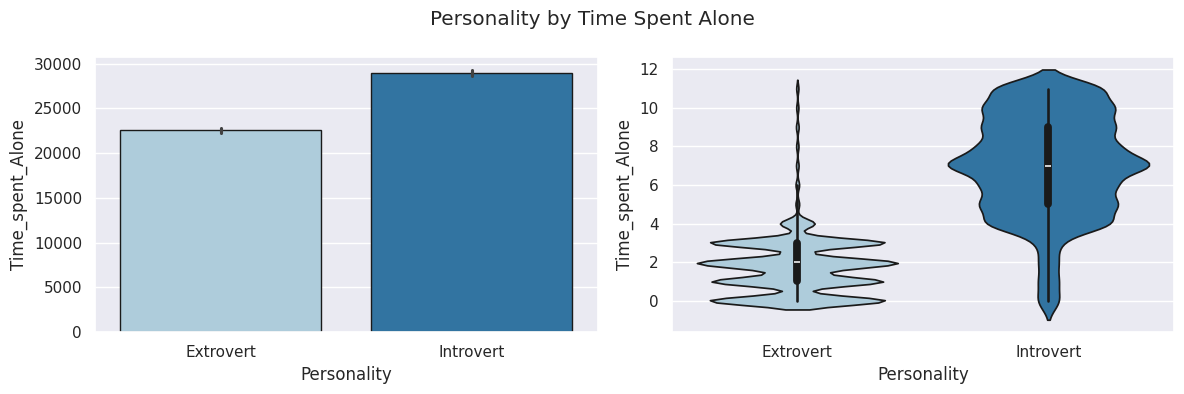

In [30]:
# We analyze personality by time spent alone

fig, axes = plt.subplots(ncols=2, figsize=(12, 4))

sns.barplot(
    data=personality_end, 
    x="Personality", 
    y="Time_spent_Alone", 
    estimator="sum", 
    edgecolor="k", 
    palette="Paired",
    ax=axes[0]
)
sns.violinplot(
    data=personality_end, 
    x="Personality", 
    y="Time_spent_Alone",
    edgecolor="k",
    palette="Paired",
    ax=axes[1]
)
plt.suptitle(t="Personality by Time Spent Alone")
plt.tight_layout()
plt.show()

We can observe that extroverts spend an average of 1 to 2 hours alone, while introverts can spend up to almost 7 hours alone. We also found that for introverts, the values range more widely, but for extroverts, the values are more consistent within a narrower range.

In [31]:
social_tsa = personality_end.pivot(columns="Friends_circle_size", values="Time_spent_Alone")

social_tsa.describe()

Friends_circle_size,0.0,1.0,2.0,3.0,3.3,4.0,5.0,6.0,7.0,8.0,9.0,9.6,10.0,11.0,12.0,13.0,14.0,15.0
count,419.000000,637.000000,657.000000,731.000000,332.000000,1187.000000,1488.000000,1078.000000,1044.000000,1179.000000,1001.000000,681.000000,1162.000000,1145.000000,1184.000000,984.000000,1088.000000,891.000000
mean,7.292601,7.356986,7.303653,6.821888,7.297289,4.758382,4.022245,1.845640,1.726628,1.758609,1.703896,1.784141,1.816179,1.724978,1.757601,1.681098,1.641360,1.675196
std,2.334804,2.316974,2.354216,2.819475,2.340906,3.468950,3.287480,1.643579,1.494233,1.429100,1.318171,1.595522,1.505184,1.297485,1.294560,1.306276,1.340605,1.352560
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.000000,5.000000,5.000000,5.000000,5.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
50%,7.100000,7.100000,7.100000,7.000000,7.100000,4.000000,3.000000,1.700000,1.700000,1.700000,2.000000,2.000000,2.000000,2.000000,1.700000,1.700000,1.700000,1.700000
75%,9.000000,9.000000,9.000000,9.000000,9.000000,8.000000,7.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000
max,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,9.000000,11.000000,11.000000,10.000000,9.000000,10.000000,11.000000,9.000000


We observe that the previously established averages for the amount of time people spend alone, taking into account their personality, impact the number of people in their social circle. We see that even when the averages for time alone are exceeded, we find the highest number of friends or the lowest number of friends.

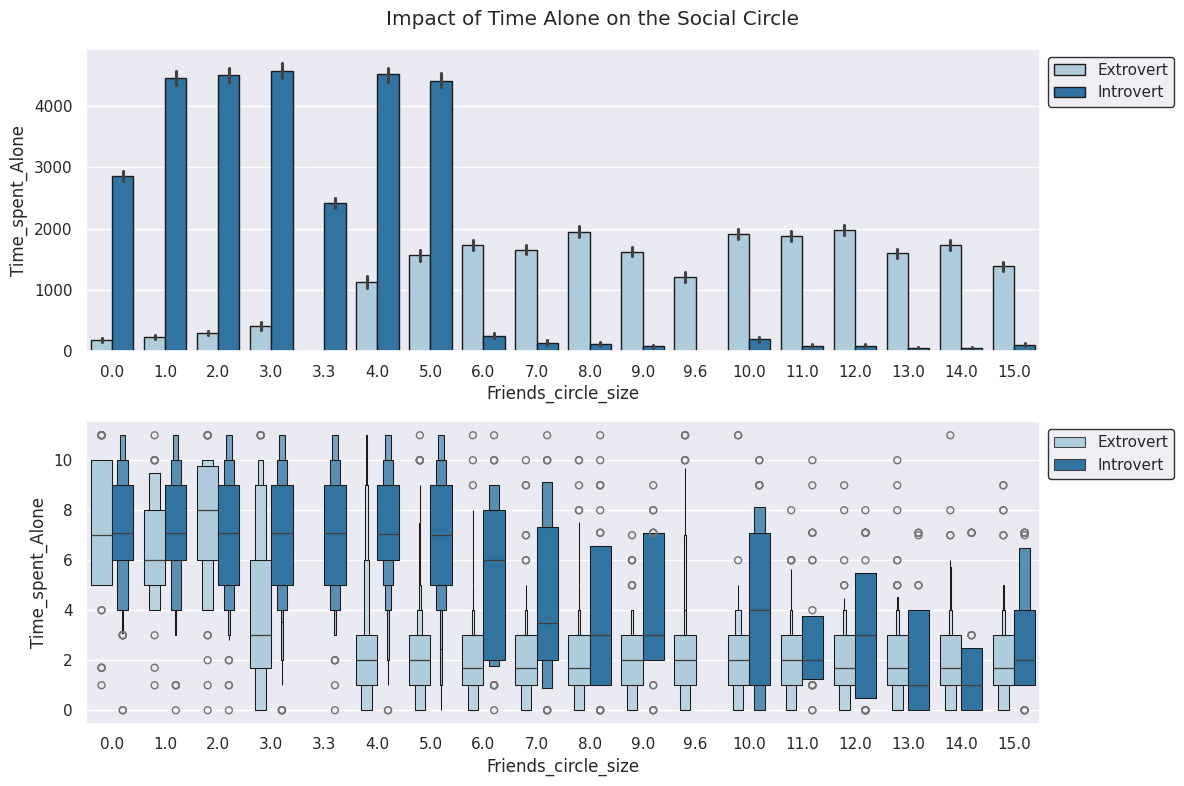

In [32]:
# We analyze the social circle

fig, axes = plt.subplots(nrows=2, figsize=(12, 8))

sns.barplot(
    data=personality_end, 
    x="Friends_circle_size", 
    y="Time_spent_Alone", 
    hue="Personality",
    estimator="sum", 
    edgecolor="k", 
    palette="Paired",
    ax=axes[0]
)
sns.boxenplot(
    data=personality_end, 
    x="Friends_circle_size", 
    y="Time_spent_Alone",
    hue="Personality",
    edgecolor="k",
    palette="Paired",
    ax=axes[1]
)

axes[0].legend(bbox_to_anchor=(1, 1),loc="upper left",edgecolor="black")
axes[1].legend(bbox_to_anchor=(1, 1),loc="upper left",edgecolor="black")
plt.suptitle(t="Impact of Time Alone on the Social Circle")
plt.tight_layout()
plt.show()

Visualizing the data confirms what we previously analyzed in our statistical analysis. We can also see that, when separating time by social circle, we find constant outliers across the range of values. We can see a negative slope, since the larger the circle of friends, the less time a person spends alone.

>- How much does fear of socializing impact going out?
>- How much does socializing impact personality-wise in terms of energy?

In [33]:
fear_go = personality_end.pivot(columns="Stage_fear", values="Going_outside")

fear_go.describe().T

,count,mean,std,min,25%,50%,75%,max
Stage_fear,,,,,,,,
No,12810.0,4.963263,1.331925,0.0,4.0,5.0,6.0,7.0
Yes,4078.0,1.368342,1.103510,0.0,0.0,1.5,2.0,7.0


We can see that for people who do not suffer from stage fright, they tend to have an average of 4 to 5 outings, but on the other hand, when fear is present, people make one outing on average.

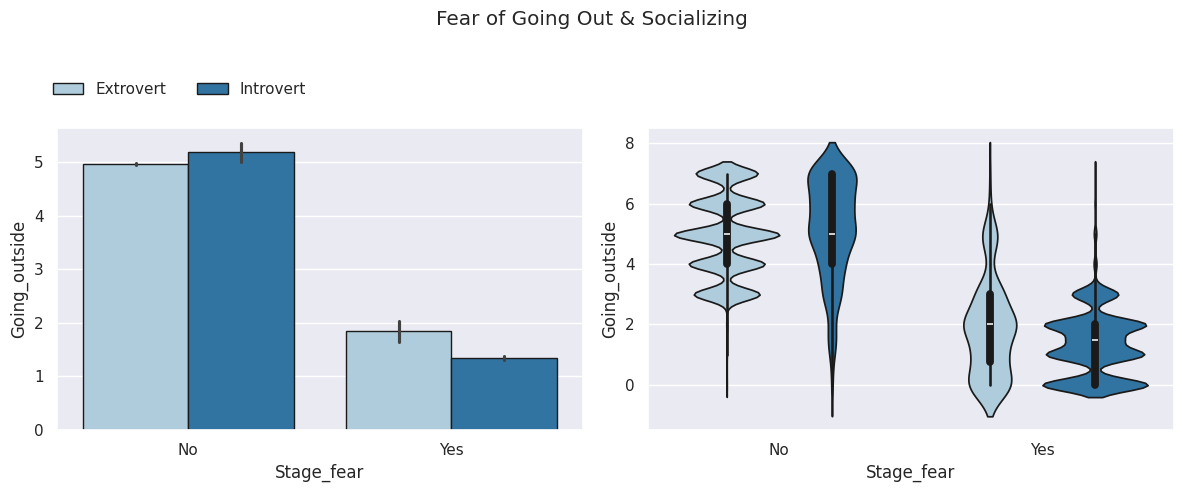

In [34]:
# We analyze personality by fear and going outside

fig, axes = plt.subplots(ncols=2, figsize=(12, 5))

sns.barplot(
    data=personality_end, 
    x="Stage_fear", 
    y="Going_outside", 
    hue="Personality", 
    edgecolor="k", 
    palette="Paired",
    ax=axes[0]
)
sns.violinplot(
    data=personality_end, 
    x="Stage_fear", 
    y="Going_outside",
    hue="Personality",
    edgecolor="k",
    palette="Paired",
    ax=axes[1]
)
sns.move_legend(
    axes[0], "upper right",
    bbox_to_anchor=(.5, 1.2), 
    ncol=2, 
    title=None, 
    frameon=False,
)

axes[1].get_legend().remove()
plt.suptitle(t="Fear of Going Out & Socializing")
plt.tight_layout()
plt.show()

We observe that stage fright is not a constant among introverts. We can even see that there are no major differences in this behavior regarding personality, which may be due to the extensive socialization of extroverts and the time introverts spend alone, which can be both at home and outdoors. Furthermore, we see that extroverts have the highest number of samples with stage fright. This may be logical, since they tend to have wider social circles and socialize more, as the inverse for introverts, who, having a lower degree of these variables, do not suffer from it as much.

In [35]:
social_drain = personality_end.pivot(columns="Drained_after_socializing", values="Social_event_attendance")

social_drain.describe().T

,count,mean,std,min,25%,50%,75%,max
Drained_after_socializing,,,,,,,,
No,12827.0,6.452756,1.906522,0.0,5.0,6.4,8.0,10.0
Yes,4061.0,1.693647,1.257703,0.0,1.0,1.9,3.0,9.0


We can see that the impact of burnout after socializing is not that great, since most samples reveal that people who socialize on average around 6 to 7 occasions do not present burnout. On the other hand, people who experience burnout tend to go on average 1 to 2 outings or social events.

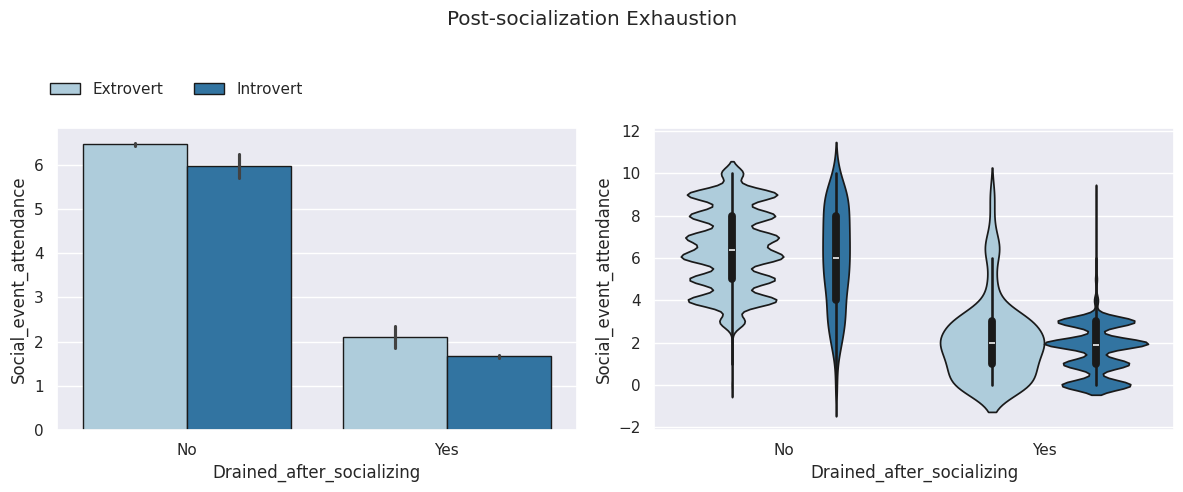

In [36]:
# We analyze personality by exhaustion and social attendance

fig, axes = plt.subplots(ncols=2, figsize=(12, 5))

sns.barplot(
    data=personality_end, 
    x="Drained_after_socializing", 
    y="Social_event_attendance", 
    hue="Personality", 
    edgecolor="k", 
    palette="Paired",
    ax=axes[0]
)
sns.violinplot(
    data=personality_end, 
    x="Drained_after_socializing", 
    y="Social_event_attendance",
    hue="Personality",
    edgecolor="k",
    palette="Paired",
    ax=axes[1]
)
sns.move_legend(
    axes[0], "upper right",
    bbox_to_anchor=(.5, 1.2), 
    ncol=2, 
    title=None, 
    frameon=False,
)

axes[1].get_legend().remove()
plt.suptitle(t="Post-socialization Exhaustion")
plt.tight_layout()
plt.show()

Analyzing the graphs, we can confirm what we previously assessed. We can also observe the same thing we found in the analysis of fear during outings or socializing: extroverts with a high level of socialization report the greatest amount of fatigue or exhaustion after social events. We can also confirm that burnout is more related not to personality, but to other factors, since we did not find significant differences by personality.

>- Is there a relationship between the amount of time a person spends on social media and their number of friends?
>- Is posting frequency related to the amount of time people spend alone or socializing?

In [37]:
fcs_post = personality_end.pivot(columns="Friends_circle_size", values="Post_frequency")

fcs_post.describe()

Friends_circle_size,0.0,1.0,2.0,3.0,3.3,4.0,5.0,6.0,7.0,8.0,9.0,9.6,10.0,11.0,12.0,13.0,14.0,15.0
count,419.000000,637.000000,657.000000,731.000000,332.000000,1187.000000,1488.000000,1078.000000,1044.000000,1179.000000,1001.000000,681.000000,1162.000000,1145.000000,1184.000000,984.000000,1088.000000,891.000000
mean,1.355370,1.470016,1.441248,1.864432,1.252410,3.501769,4.070901,6.081076,6.070977,6.242494,6.234565,6.052717,6.143804,6.208297,6.182855,6.292480,6.224632,6.101122
std,1.042833,1.277722,1.215043,1.893592,1.312188,2.812119,2.916522,2.257692,2.153583,2.110460,2.116106,2.231558,2.179317,2.105141,2.132976,2.133491,2.131561,2.074484
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000,0.000000
25%,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.600000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,5.000000,4.000000,5.000000,4.000000,4.000000
50%,1.000000,1.600000,1.600000,1.600000,1.000000,3.000000,3.000000,6.000000,6.000000,6.100000,6.100000,6.000000,6.000000,6.000000,6.000000,6.100000,6.000000,6.000000
75%,2.000000,2.000000,2.000000,2.000000,2.000000,6.000000,6.100000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000
max,6.100000,9.000000,9.000000,9.000000,9.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000


It's logical to find that the larger a person's social circle, the greater their social media participation. We see averages of 1 to 2 posts for smaller circles, and an average of up to 6 posts for larger social circles.

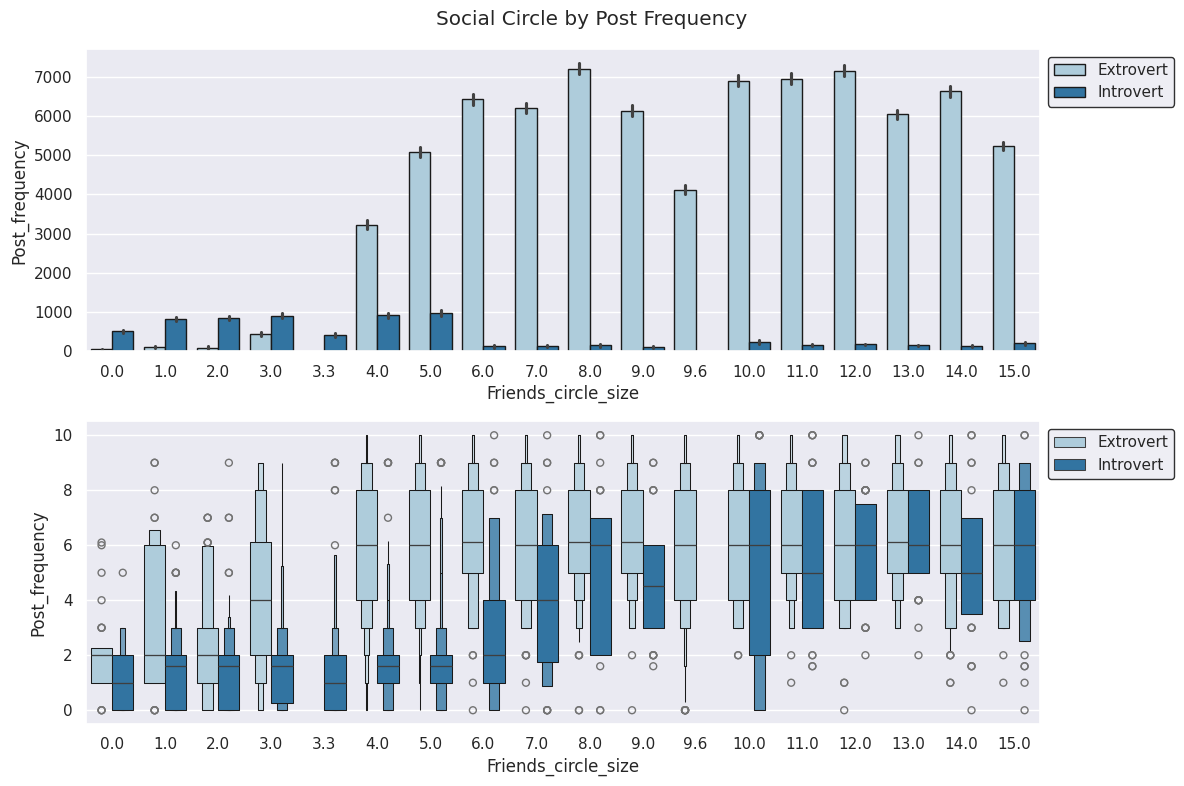

In [38]:
# We analyze the social circle and post frequency

fig, axes = plt.subplots(nrows=2, figsize=(12, 8))

sns.barplot(
    data=personality_end, 
    x="Friends_circle_size", 
    y="Post_frequency", 
    hue="Personality",
    estimator="sum", 
    edgecolor="k", 
    palette="Paired",
    ax=axes[0]
)
sns.boxenplot(
    data=personality_end, 
    x="Friends_circle_size", 
    y="Post_frequency",
    hue="Personality",
    edgecolor="k",
    palette="Paired",
    ax=axes[1]
)

axes[0].legend(bbox_to_anchor=(1, 1),loc="upper left",edgecolor="black")
axes[1].legend(bbox_to_anchor=(1, 1),loc="upper left",edgecolor="black")
plt.suptitle(t="Social Circle by Post Frequency")
plt.tight_layout()
plt.show()

We also observed a positive relationship between the variables, and the presence of outliers when analyzing them, particularly the highest values. This finding is logical, since an introverted person can lead a more withdrawn life and still be highly or actively involved in social media.

In [39]:
tsa_post = personality_end.pivot(columns="Time_spent_Alone", values="Post_frequency")

tsa_post.describe()

Time_spent_Alone,0.0,1.0,1.7,2.0,3.0,4.0,5.0,6.0,7.0,7.1,8.0,9.0,10.0,11.0
count,2857.000000,2773.000000,893.000000,2815.000000,2857.000000,994.000000,527.000000,505.000000,517.000000,255.000000,489.000000,493.000000,486.000000,427.000000
mean,6.169163,6.163902,5.874356,6.205187,6.150368,4.294668,1.742315,1.618812,1.468472,1.719216,1.589980,1.480933,1.487449,1.388759
std,2.088498,2.132511,2.052883,2.151968,2.179695,3.153601,1.737216,1.548534,1.348597,1.869498,1.435528,1.240477,1.320663,1.141889
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.000000,4.000000,4.000000,4.000000,4.000000,1.600000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.500000
50%,6.000000,6.000000,6.000000,6.000000,6.000000,4.000000,1.600000,1.600000,1.600000,1.600000,1.600000,1.600000,1.600000,1.000000
75%,8.000000,8.000000,7.000000,8.000000,8.000000,7.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
max,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,9.000000,9.000000,9.000000,9.000000


In [40]:
go_post = personality_end.pivot(columns="Going_outside", values="Post_frequency")

go_post.describe()

Going_outside,0.0,1.0,1.5,2.0,3.0,4.0,4.9,5.0,6.0,7.0
count,1073.000000,963.000000,486.000000,1051.000000,2630.000000,2510.000000,945.000000,2650.000000,2505.000000,2075.000000
mean,1.411650,1.377778,1.218519,1.410942,5.306236,6.156574,5.900212,6.193887,6.243952,6.300193
std,1.137326,1.088087,1.287940,1.135909,2.612497,2.146708,2.156450,2.126542,2.114686,2.138051
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,1.000000,1.000000,0.000000,1.000000,3.000000,4.000000,4.000000,4.000000,4.000000,4.000000
50%,1.600000,1.600000,1.000000,1.600000,6.000000,6.000000,6.000000,6.000000,6.000000,6.100000
75%,2.000000,2.000000,2.000000,2.000000,7.000000,8.000000,8.000000,8.000000,8.000000,8.000000
max,9.000000,7.000000,9.000000,9.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000


Analyzing these values, we can deduce that people who spend more time alone tend to engage in other activities and don't spend as much time on social media, averaging one post. On the other hand, people who spend their time in company or who probably live with other people spend a lot of time on social media, averaging six posts. Regarding people's average time spent outdoors, we observe the same logic as with time spent alone. People who engage in more outdoor activity or whose lives are mostly outdoors spend more time on social media than people who tend to stay home more.

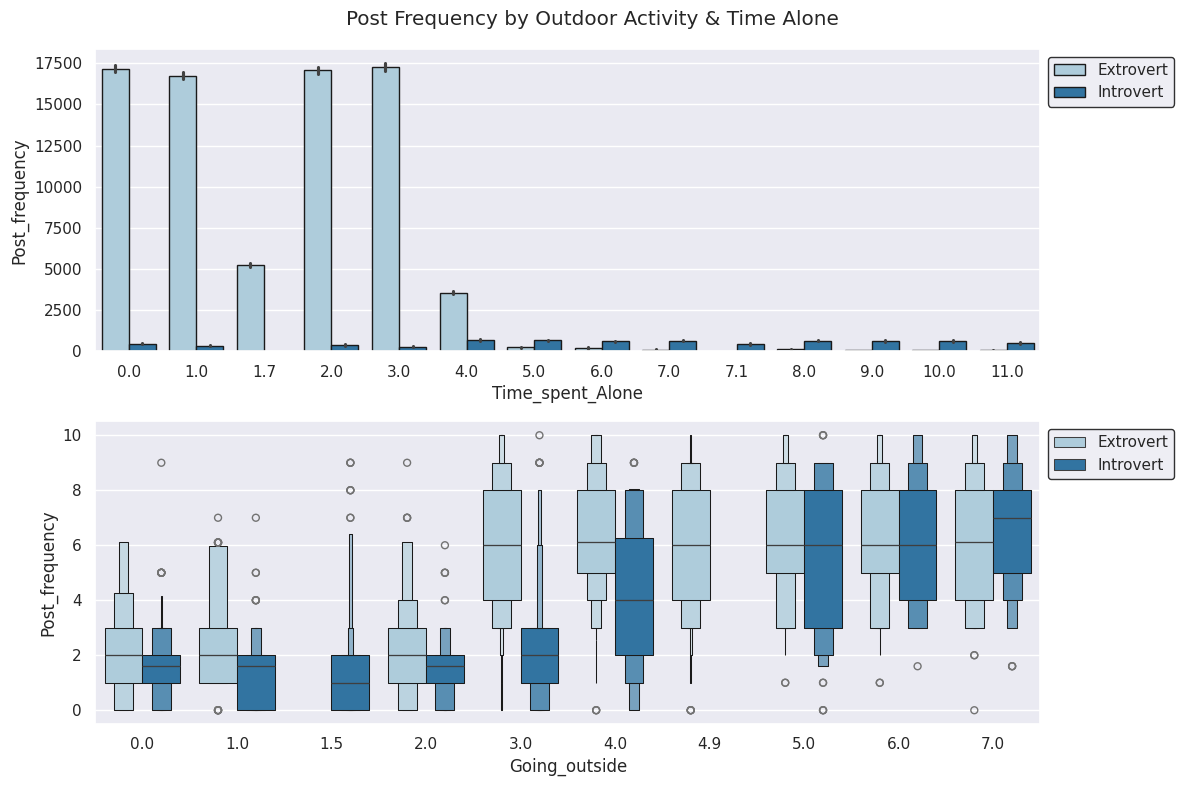

In [41]:
# We analyze the Post frequency by outdoor activity and time alone

fig, axes = plt.subplots(nrows=2, figsize=(12, 8))

sns.barplot(
    data=personality_end, 
    x="Time_spent_Alone", 
    y="Post_frequency", 
    hue="Personality",
    estimator="sum", 
    edgecolor="k", 
    palette="Paired",
    ax=axes[0]
)
sns.boxenplot(
    data=personality_end, 
    x="Going_outside", 
    y="Post_frequency",
    hue="Personality",
    edgecolor="k",
    palette="Paired",
    ax=axes[1]
)

axes[0].legend(bbox_to_anchor=(1, 1),loc="upper left",edgecolor="black")
axes[1].legend(bbox_to_anchor=(1, 1),loc="upper left",edgecolor="black")
plt.suptitle(t="Post Frequency by Outdoor Activity & Time Alone")
plt.tight_layout()
plt.show()

Analyzing the graphs, the topic becomes more interesting, since we can differentiate between personalities, rather than just looking at the data as a whole. Introverts have a nearly average level of participation in terms of the amount of time they spend on social media, regardless of how much time they spend alone. On the other hand, extroverts arguably spend a lot of time on social media when they're with others or in an average family setting, giving a negative relationship between these variables. Looking at the amount of activity, or the amount of time they spend outdoors, we see a positive relationship, with both personalities maintaining a similar average level of posting when they make the most outings.

Next, we'll preprocess the data. We'll attempt to expand our features, encode categorical variables, and perform the descriptive analysis necessary to evaluate the scaling of the values before moving on to our model selection.

# Data Preprocessing

We'll start by separating the features from the target variable. We'll then perform initial feature engineering, as well as encoding and scaling the data where necessary.

In [42]:
# We separate the target variable from the features

x_personality = personality_end.drop(columns="Personality")
y_personality = personality_end["Personality"]

In [43]:
x_personality.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16888 entries, 0 to 16887
Data columns (total 7 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   Time_spent_Alone           16888 non-null  float64 
 1   Stage_fear                 16888 non-null  category
 2   Social_event_attendance    16888 non-null  float64 
 3   Going_outside              16888 non-null  float64 
 4   Drained_after_socializing  16888 non-null  category
 5   Friends_circle_size        16888 non-null  float64 
 6   Post_frequency             16888 non-null  float64 
dtypes: category(2), float64(5)
memory usage: 693.0 KB


## Feature Engineering

We will initially keep a simple approach, creating some features from groups, to augment our data. Something important to keep in mind is that performing or returning to exploratory analysis or asking new questions of interest can be important after creating new features, in order to analyze them in depth.

In [44]:
x_personality.describe().T

,count,mean,std,min,25%,50%,75%,max
Time_spent_Alone,16888.0,3.047643,2.903997,0.0,1.0,2.0,4.0,11.0
Social_event_attendance,16888.0,5.308349,2.697769,0.0,3.0,6.0,7.0,10.0
Going_outside,16888.0,4.095186,2.001716,0.0,3.0,4.0,6.0,7.0
Friends_circle_size,16888.0,8.052712,4.137245,0.0,5.0,8.0,11.0,15.0
Post_frequency,16888.0,5.034847,2.813650,0.0,3.0,5.0,7.0,10.0


In [45]:
# We separate the variables into bins

bins_time_alone = [-1.0, 1.0, 3.0, 12.0]
bins_events = [-1.0, 3.0, 6.0, 11.0]
bins_go_out = [-1.0, 3.0, 5.0, 8.0]
bins_friends = [-1.0, 5.0, 9.0, 16.0]
bins_posts = [-1.0, 3.0, 6.0, 11.0]

# Specify bin labels

labels_personality = ["Little", "Normal", "A Lot"]

# We create the new features

x_personality["Time_Alone_Bins"] = pd.cut(
    x_personality["Time_spent_Alone"], bins_time_alone, labels=labels_personality
)
x_personality["Social_Events_Bins"] = pd.cut(
    x_personality["Social_event_attendance"], bins_events, labels=labels_personality
)
x_personality["Go_outside_Bins"] = pd.cut(
    x_personality["Going_outside"], bins_go_out, labels=labels_personality
)
x_personality["Friend_Circle_Bins"] = pd.cut(
    x_personality["Friends_circle_size"], bins_friends, labels=labels_personality
)
x_personality["Post_Freq_Bins"] = pd.cut(
    x_personality["Post_frequency"], bins_posts, labels=labels_personality
)

We will evaluate the distributions of the new variables. It is important to return to the bin separation of each new feature and modify where necessary if a very unbalanced distribution is detected.

In [46]:
# We review the new variables

x_personality.describe(exclude = np.number).T

,count,unique,top,freq
Stage_fear,16888,2,No,12810
Drained_after_socializing,16888,2,No,12827
Time_Alone_Bins,16888,3,Normal,6565
Social_Events_Bins,16888,3,A Lot,6760
Go_outside_Bins,16888,3,Little,6203
Friend_Circle_Bins,16888,3,A Lot,7135
Post_Freq_Bins,16888,3,A Lot,6325


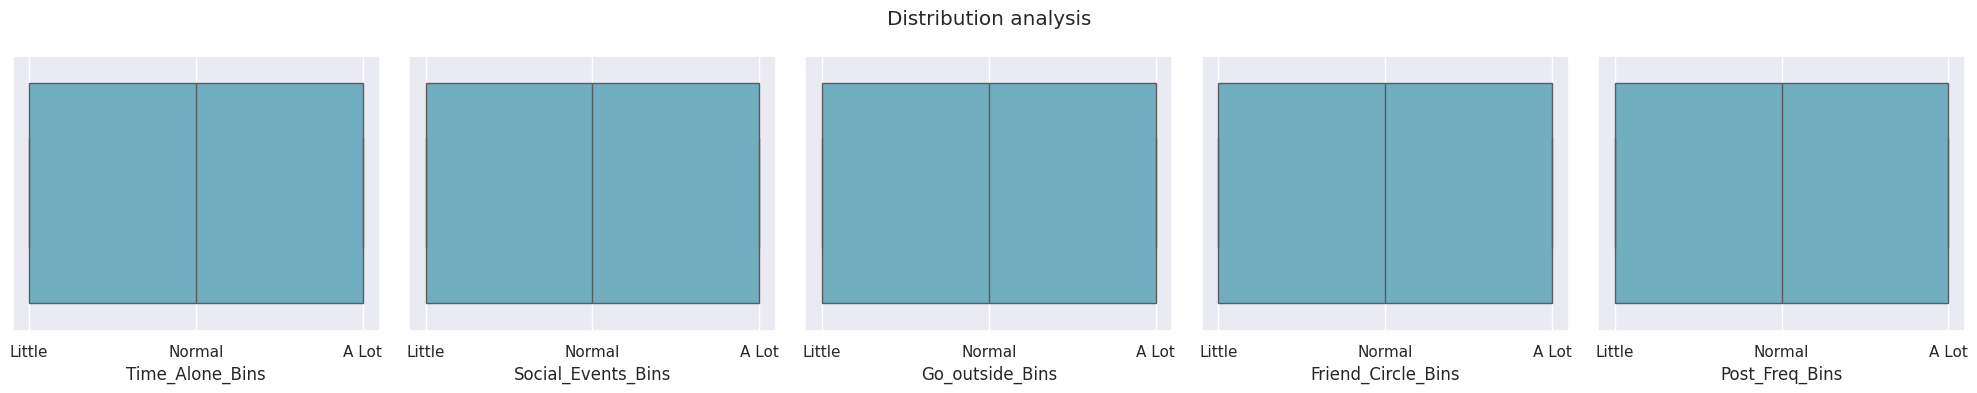

In [47]:
# We evaluate the distribution of the new variables

fig, axes = plt.subplots(ncols=5, figsize=(20, 4))

sns.boxplot(x=x_personality["Time_Alone_Bins"], color="c", ax=axes[0])
sns.boxplot(x=x_personality["Social_Events_Bins"], color="c", ax=axes[1])
sns.boxplot(x=x_personality["Go_outside_Bins"], color="c", ax=axes[2])
sns.boxplot(x=x_personality["Friend_Circle_Bins"], color="c", ax=axes[3])
sns.boxplot(x=x_personality["Post_Freq_Bins"], color="c", ax=axes[4])

plt.suptitle(t="Distribution analysis")
plt.tight_layout()
plt.show()

We've finished creating new features. I recommend extending this section by adding new transformations or combinations of variables, such as social activity, energy use, or ratios. It's also important to thoroughly evaluate and analyze all these new created features, as well as how much importance they add to our model.

## Encoding

We'll encode the data where necessary. For our target variable, we'll use LabelEncoder, which is the most appropriate tool. For the features, we'll use OneHotEncoder, with the drop="if_binary" parameter set, since our two categorical variables contain dichotomous data. For the features we create, we'll use a function to map the values.

In [48]:
# We apply LabelEncoder to the target variable

le = LabelEncoder()

y_personality = le.fit_transform(y_personality)

le_values = le.classes_

print(le_values)

['Extrovert' 'Introvert']


In [49]:
x_personality.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16888 entries, 0 to 16887
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   Time_spent_Alone           16888 non-null  float64 
 1   Stage_fear                 16888 non-null  category
 2   Social_event_attendance    16888 non-null  float64 
 3   Going_outside              16888 non-null  float64 
 4   Drained_after_socializing  16888 non-null  category
 5   Friends_circle_size        16888 non-null  float64 
 6   Post_frequency             16888 non-null  float64 
 7   Time_Alone_Bins            16888 non-null  category
 8   Social_Events_Bins         16888 non-null  category
 9   Go_outside_Bins            16888 non-null  category
 10  Friend_Circle_Bins         16888 non-null  category
 11  Post_Freq_Bins             16888 non-null  category
dtypes: category(7), float64(5)
memory usage: 776.1 KB


In [50]:
# We apply OneHotEncoder to the original categorical variables

cat_cols = x_personality[["Stage_fear", "Drained_after_socializing"]]
rest_cols = x_personality.drop(columns=["Stage_fear", "Drained_after_socializing"])
encoder = OneHotEncoder(sparse=False, drop="if_binary").set_output(transform="pandas")
cat_enc = encoder.fit_transform(cat_cols)

# We changed the name of the encoded columns

cat_enc.rename(
    columns={"Stage_fear_Yes": "Stage_fear", 
             "Drained_after_socializing_Yes": "Drained_after_socializing"}, 
    inplace=True)

In [51]:
# We create a useful function

def mapper(data, column, order):
    
    data[column] = data[column].map(order)
    data[column] = data[column].astype("float64")

    print(data[column].value_counts())

In [52]:
# We map the variables labels

bins_order = {"Little" : 0, "Normal" : 1, "A Lot" : 2}

# We use a for loop to apply the function to the desired columns

for column in rest_cols.columns:
    if isinstance(rest_cols[column].dtype, pd.CategoricalDtype):
        mapper(rest_cols, column, bins_order)

Time_Alone_Bins
1.0    6565
0.0    5630
2.0    4693
Name: count, dtype: int64
Social_Events_Bins
2.0    6760
1.0    5570
0.0    4558
Name: count, dtype: int64
Go_outside_Bins
0.0    6203
1.0    6105
2.0    4580
Name: count, dtype: int64
Friend_Circle_Bins
2.0    7135
0.0    5451
1.0    4302
Name: count, dtype: int64
Post_Freq_Bins
2.0    6325
0.0    5699
1.0    4864
Name: count, dtype: int64


In [53]:
# We join the two resulting df

df_encoded = pd.concat([cat_enc, rest_cols], axis=1)

df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16888 entries, 0 to 16887
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Stage_fear                 16888 non-null  float64
 1   Drained_after_socializing  16888 non-null  float64
 2   Time_spent_Alone           16888 non-null  float64
 3   Social_event_attendance    16888 non-null  float64
 4   Going_outside              16888 non-null  float64
 5   Friends_circle_size        16888 non-null  float64
 6   Post_frequency             16888 non-null  float64
 7   Time_Alone_Bins            16888 non-null  float64
 8   Social_Events_Bins         16888 non-null  float64
 9   Go_outside_Bins            16888 non-null  float64
 10  Friend_Circle_Bins         16888 non-null  float64
 11  Post_Freq_Bins             16888 non-null  float64
dtypes: float64(12)
memory usage: 1.5 MB


We've finished encoding the data, and now we'll scale it. Remember to try different alternatives to data preprocessing.

## Scaling

Next, we'll scale the features using RobustScaler, which scales using statistics that are robust to outliers. Having found some extreme values when analyzing the data in more depth, we chose this tool. I invite you to try different approaches to scaling the data, such as MinMaxScaler or StandardScaler.

https://scikit-learn.org/stable/api/sklearn.preprocessing.html

In [54]:
df_encoded.describe().T

,count,mean,std,min,25%,50%,75%,max
Stage_fear,16888.0,0.241473,0.427989,0.0,0.0,0.0,0.0,1.0
Drained_after_socializing,16888.0,0.240467,0.427379,0.0,0.0,0.0,0.0,1.0
Time_spent_Alone,16888.0,3.047643,2.903997,0.0,1.0,2.0,4.0,11.0
Social_event_attendance,16888.0,5.308349,2.697769,0.0,3.0,6.0,7.0,10.0
Going_outside,16888.0,4.095186,2.001716,0.0,3.0,4.0,6.0,7.0
Friends_circle_size,16888.0,8.052712,4.137245,0.0,5.0,8.0,11.0,15.0
Post_frequency,16888.0,5.034847,2.813650,0.0,3.0,5.0,7.0,10.0
Time_Alone_Bins,16888.0,0.944517,0.779885,0.0,0.0,1.0,2.0,2.0
Social_Events_Bins,16888.0,1.130388,0.808219,0.0,0.0,1.0,2.0,2.0
Go_outside_Bins,16888.0,0.903896,0.793286,0.0,0.0,1.0,2.0,2.0


In [55]:
# Numerical variables to scale

personality_numeric = df_encoded[[
    "Time_spent_Alone",
    "Social_event_attendance",
    "Going_outside",
    "Friends_circle_size",
    "Post_frequency"
]]

scaler = RobustScaler().set_output(transform="pandas")
x_scale = scaler.fit_transform(personality_numeric)

# We create a df with the remaining variables

x_rest = df_encoded.drop(columns=[
    "Time_spent_Alone",
    "Social_event_attendance",
    "Going_outside",
    "Friends_circle_size",
    "Post_frequency"
])

# We concatenate the dataframes

x_end = pd.concat([x_scale, x_rest], axis=1)

In [56]:
x_end.describe().T

,count,mean,std,min,25%,50%,75%,max
Time_spent_Alone,16888.0,0.349214,0.967999,-0.666667,-0.333333,0.0,0.666667,3.000000
Social_event_attendance,16888.0,-0.172913,0.674442,-1.500000,-0.750000,0.0,0.250000,1.000000
Going_outside,16888.0,0.031729,0.667239,-1.333333,-0.333333,0.0,0.666667,1.000000
Friends_circle_size,16888.0,0.008785,0.689541,-1.333333,-0.500000,0.0,0.500000,1.166667
Post_frequency,16888.0,0.008712,0.703412,-1.250000,-0.500000,0.0,0.500000,1.250000
Stage_fear,16888.0,0.241473,0.427989,0.000000,0.000000,0.0,0.000000,1.000000
Drained_after_socializing,16888.0,0.240467,0.427379,0.000000,0.000000,0.0,0.000000,1.000000
Time_Alone_Bins,16888.0,0.944517,0.779885,0.000000,0.000000,1.0,2.000000,2.000000
Social_Events_Bins,16888.0,1.130388,0.808219,0.000000,0.000000,1.0,2.000000,2.000000
Go_outside_Bins,16888.0,0.903896,0.793286,0.000000,0.000000,1.0,2.000000,2.000000


We finished scaling the data where we deemed necessary after evaluating their ranges and scales. Other tools, as previously mentioned, can be applied. Unscaled data could also be used, since after the analysis, we found a range of unit values for all the variables to be scaled. We will continue with feature selection, where we will evaluate the relationship of the features.

## Feature Selection

We'll first analyze correlation to assess the linear relationship between the features. We'll then use 'mutual_info_classif' to analyze the possible dependencies between the variables, and how much information one variable provides about the other.

<Axes: >

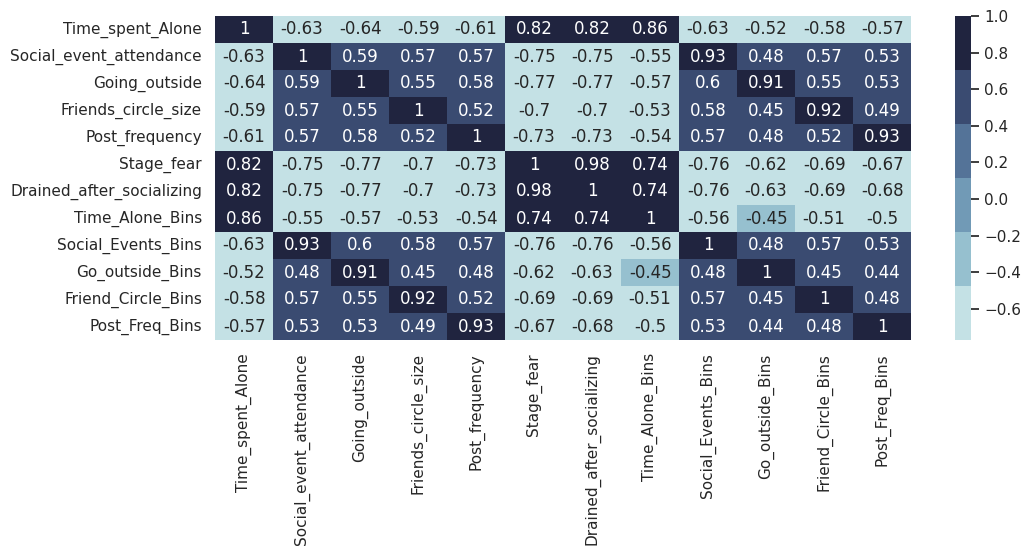

In [57]:
# We graph the correlation between the variables

matrix_calories = x_end.corr(numeric_only=True).round(2)

plt.figure(figsize=(10, 4))

sns.heatmap(
    matrix_calories, 
    annot=True,
    cmap=sns.cubehelix_palette(rot=-.2)
    )

We can see, as is logical, that the created variables are highly correlated with the corresponding source features. In general, we find variables with a high positive or negative linear relationship. We will continue to analyze mutual information.

In [58]:
personality_scores = mutual_info_classif(x_end, y_personality)
personality_scores = pd.Series(personality_scores, name="Personality MI Scores", index=x_end.columns)
personality_scores = personality_scores.sort_values(ascending=False)
personality_scores

Stage_fear                   0.423565
Drained_after_socializing    0.418317
Time_spent_Alone             0.376221
Social_event_attendance      0.367255
Going_outside                0.357439
Post_frequency               0.357431
Time_Alone_Bins              0.343885
Social_Events_Bins           0.343532
Friends_circle_size          0.316345
Friend_Circle_Bins           0.271313
Post_Freq_Bins               0.260195
Go_outside_Bins              0.229709
Name: Personality MI Scores, dtype: float64

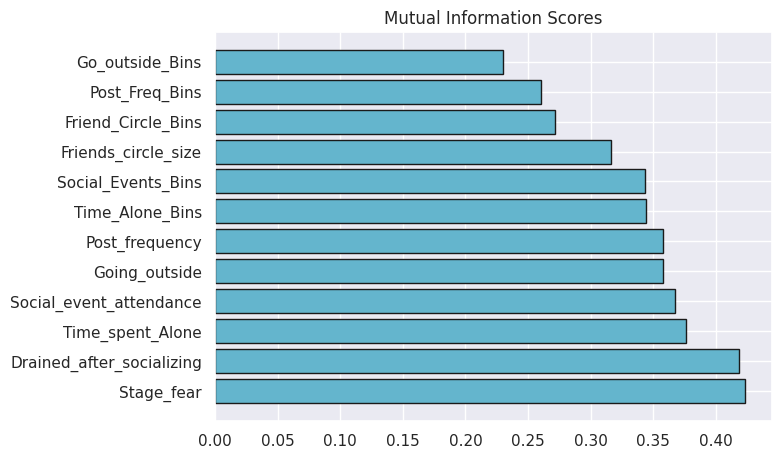

<Figure size 800x500 with 0 Axes>

In [59]:
scores = personality_scores.sort_values()
width = np.arange(len(personality_scores))
ticks = list(personality_scores.index)
plt.barh(width, personality_scores, color="c", edgecolor="k")
plt.yticks(width, ticks)
plt.title("Mutual Information Scores")
plt.figure(dpi=100, figsize=(8, 5))
plt.show()

We can see that some of the created variables contain slightly less information. But overall, they don't show independence. We could use this information to get rid of variables we consider useless or return to feature creation and expand them. Uncomment the following cell and add the columns you want to remove. Remember to replace the final data frame if you do so.

In [60]:
# We remove the variables that we will not use

#x_final = x_end.drop(columns="")

In [61]:
x_end.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16888 entries, 0 to 16887
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Time_spent_Alone           16888 non-null  float64
 1   Social_event_attendance    16888 non-null  float64
 2   Going_outside              16888 non-null  float64
 3   Friends_circle_size        16888 non-null  float64
 4   Post_frequency             16888 non-null  float64
 5   Stage_fear                 16888 non-null  float64
 6   Drained_after_socializing  16888 non-null  float64
 7   Time_Alone_Bins            16888 non-null  float64
 8   Social_Events_Bins         16888 non-null  float64
 9   Go_outside_Bins            16888 non-null  float64
 10  Friend_Circle_Bins         16888 non-null  float64
 11  Post_Freq_Bins             16888 non-null  float64
dtypes: float64(12)
memory usage: 1.5 MB


We have completed data preprocessing. For now, we will retain this approach, along with all the features, and after conducting our initial training session with its corresponding analysis and evaluation of results, we will return to these points and test new methods or tools if necessary. We will continue with our model selection.

# Model Selection

We'll begin with a general model selection process, with the goal of initially testing our data and seeing how it performs, as well as the performance we get from the models. To start, we'll separate the data into training and validation sets and develop some useful functions to evaluate the model using competition-specific metrics and analyze the prediction results.

In [62]:
# We separate the data into training and validation sets

x_train, x_val, y_train, y_val = (
    train_test_split(x_end, y_personality, test_size=0.2, random_state=42)
)

In [63]:
# We review the balance of the target variable

values_counts = np.asarray(np.unique(y_train, return_counts=True))

print(values_counts)

[[    0     1]
 [10184  3326]]


As we had already analyzed when exploring the data, we found an unbalanced target variable. We could initially maintain the unbalanced classes when selecting the model to make our first approach and then consider applying a method to balance them.

In [64]:
def evaluator(model, xtrain, ytrain, xval, yval):

    '''
    We calculate the precision score
    We obtain prediction from the model
    We calculate the f1 score
    Train result and accuracy score test
    Print train and test macro f1 score
    '''

    train_ascore = model.score(xtrain, ytrain)
    val_ascore = model.score(xval, yval)

    y_train_pred = model.predict(xtrain)
    y_val_pred = model.predict(xval)

    train_fscore = f1_score(ytrain, y_train_pred, average="macro")
    val_fscore = f1_score(yval, y_val_pred, average="macro")

    print(f"Train -------> Accuracy score: {train_ascore}")
    print(f"Validation --> Accuracy score: {val_ascore}\n")
    print(f"Train -------> F1-Score: {train_fscore}")
    print(f"Validation --> F1-Score: {val_fscore}")

In [65]:
def matrix_evaluator(model, xval, yval, list_classes, color_map):
    
    '''
    We create the confusion matrix
    We plot the confusion matrix
    Report results
    '''
    
    y_pred = model.predict(xval)
    cm_values = confusion_matrix(yval, y_pred)
    df_cm = pd.DataFrame(
        cm_values,
        columns=list_classes,
        index=list_classes
        )
    df_cm.index.name = "Actual"
    df_cm.columns.name = "Predicted"

    plt.figure(figsize=(6, 4))
    sns.heatmap(df_cm, annot=True, fmt="d", cmap=color_map)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

    print("\n")
    print(classification_report(
        yval, y_pred, target_names=list_classes
    ))

These two functions cover the initial analysis with the chosen metrics, and allow us to see the quality of the predictions, as well as obtain a report. Once the initial steps have been completed, we can begin testing the selected models.

## First model: LogisticRegression

We'll try a linear model as our first option. For this, we'll choose LogisticRegression, which is used for binary classification problems (two possible outcomes) where the output variable is categorical. It predicts the probability of belonging to a class. Instead of directly predicting the outcome, logistic regression uses the sigmoid function (also known as the logistic function) to map the output of a linear equation to a probability.

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

In [66]:
# We create the model instance

lrc = LogisticRegression()

# Train the model with the data

lrc.fit(x_train, y_train)

LogisticRegression()

In [67]:
# We evaluate the accuracy and the f1-score

evaluator(lrc, x_train, y_train, x_val, y_val)

Train -------> Accuracy score: 0.9664692820133235
Validation --> Accuracy score: 0.9692125518058022

Train -------> F1-Score: 0.954594407294435
Validation --> F1-Score: 0.9575606814412784


Analyzing the accuracy and F1 scores, we can deduce that we did not find any potential overfitting, since our validation results are slightly higher than the training results. Given the data, we likely found overfitting across the models we test.

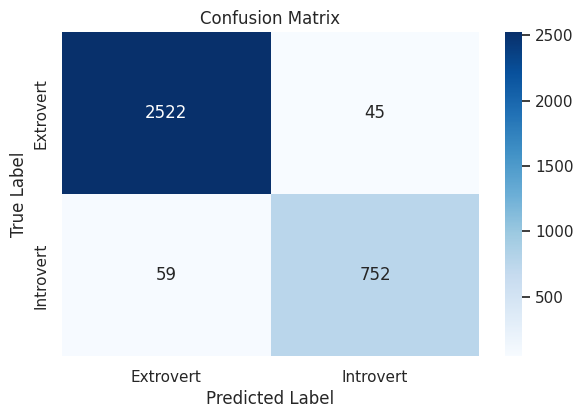



              precision    recall  f1-score   support

   Extrovert       0.98      0.98      0.98      2567
   Introvert       0.94      0.93      0.94       811

    accuracy                           0.97      3378
   macro avg       0.96      0.95      0.96      3378
weighted avg       0.97      0.97      0.97      3378



In [68]:
# We graph the confusion matrix

matrix_evaluator(
    lrc, 
    x_val, 
    y_val, 
    ["Extrovert", "Introvert"], 
    "Blues"
)

The model handles both classes very well. With a 98% overall accuracy for extroverts, it almost never makes a mistake, and with a 94% accuracy for introverts, it also has a 93% recall rate. This slight imbalance in performance is completely normal, given that the Introvert class has fewer samples than the Extrovert class.

## Second model: LGBMClassifier

The second model we will test is LGBMClassifier, an open-source high-performance gradient boosting framework developed by Microsoft. It is known for its speed and efficiency, especially when handling large datasets.

https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html

In [69]:
# We create the model instance

lgbmc = LGBMClassifier()

# Train the model with the data

lgbmc.fit(x_train, y_train)

[LightGBM] [Info] Number of positive: 3326, number of negative: 10184
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003359 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 87
[LightGBM] [Info] Number of data points in the train set: 13510, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.246188 -> initscore=-1.119047
[LightGBM] [Info] Start training from score -1.119047


LGBMClassifier()

In [70]:
# We evaluate the accuracy and the f1-score

evaluator(lgbmc, x_train, y_train, x_val, y_val)

Train -------> Accuracy score: 0.9807549962990377
Validation --> Accuracy score: 0.9760213143872114

Train -------> F1-Score: 0.9739367227614044
Validation --> F1-Score: 0.9668753727940007


We can clearly identify the model as having an overfitting problem. The training results are higher than the validation results. Even so, the difference is not that large, and this is common in tree-based models with a high capacity to fit the data, something we can improve with hyperparameter optimization.

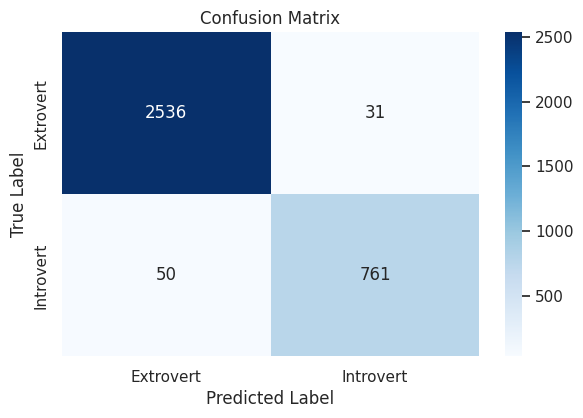



              precision    recall  f1-score   support

   Extrovert       0.98      0.99      0.98      2567
   Introvert       0.96      0.94      0.95       811

    accuracy                           0.98      3378
   macro avg       0.97      0.96      0.97      3378
weighted avg       0.98      0.98      0.98      3378



In [71]:
# We graph the confusion matrix

matrix_evaluator(
    lgbmc, 
    x_val, 
    y_val, 
    ["Extrovert", "Introvert"], 
    "Blues"
)

Analyzing the confusion matrix and the report, the model handles the extrovert class almost perfectly, with a recall of 0.99, but maintains a bit of confusion for the other class, although an improvement over the previous model, since it reduced the number of misclassified introverts, in addition to the precision in predicting this class.

## Third model: BaggingClassifier

As a third and final model, we chose BaggingClassifier to test an ensemble method. An ensemble meta-estimator that fits base classifiers each on random subsets of the original dataset and then aggregates their individual predictions (either by voting or by averaging) to form a final prediction. We will initially use the model with its base estimator DecisionTreeClassifier, and then with the two previously tested models.

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html

In [72]:
# We create the model instance

bagc = BaggingClassifier(estimator=LGBMClassifier())

# Train the model with the data

bagc.fit(x_train, y_train)

[LightGBM] [Info] Number of positive: 3326, number of negative: 10184
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001543 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 87
[LightGBM] [Info] Number of data points in the train set: 13510, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.249593 -> initscore=-1.100785
[LightGBM] [Info] Start training from score -1.100785
[LightGBM] [Info] Number of positive: 3326, number of negative: 10184
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000921 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 87
[LightGBM] [Info] Number of data points in the train set: 13510, number of used features: 12
[LightGBM] [Info] [binar

BaggingClassifier(estimator=LGBMClassifier())

In [73]:
# We evaluate the accuracy and the f1-score

#evaluator(bagc, x_train, y_train, x_val, y_val)

Base estimator DecisionTreeClassifier:

    Train -------> Accuracy score: 0.9931902294596595
    Validation --> Accuracy score: 0.9692125518058022
    
    Train -------> F1-Score: 0.9907926984940477
    Validation --> F1-Score: 0.9573410269860698

Base estimator LogisticRegression:

    Train -------> Accuracy score: 0.9663952627683198
    Validation --> Accuracy score: 0.9689165186500888
    
    Train -------> F1-Score: 0.9545081623847236
    Validation --> F1-Score: 0.9571709213389856

Base estimator LGBMClassifier:

    Train -------> Accuracy score: 0.979718726868986
    Validation --> Accuracy score: 0.9760213143872114
    
    Train -------> F1-Score: 0.9725107517095326
    Validation --> F1-Score: 0.9668182666522598

The results don't differ much from those obtained with previous models, taking each estimator into account. LGBMClassifier generally achieved the best results, although we are finding a clear problem of overfitting, especially when looking at the results with DecisionTreeClassifier. We could perform this step using GridSearchCV, passing all the models to the 'estimator' key, but we do it this way to obtain an initial result and evaluate whether we will use the model.

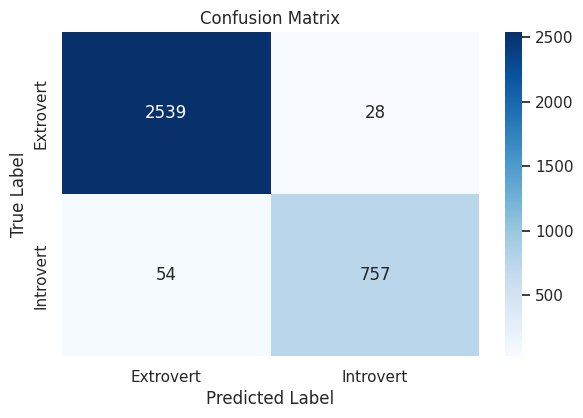



              precision    recall  f1-score   support

   Extrovert       0.98      0.99      0.98      2567
   Introvert       0.96      0.93      0.95       811

    accuracy                           0.98      3378
   macro avg       0.97      0.96      0.97      3378
weighted avg       0.98      0.98      0.98      3378



In [74]:
# We graph the confusion matrix

matrix_evaluator(
    bagc, 
    x_val, 
    y_val, 
    ["Extrovert", "Introvert"], 
    "Blues"
)

The matrix and report are based on BaggingClassifier (estimator=LGBMClassifier). The results are almost identical to those obtained with LGBMClassifier. The model handles classes within the same parameters. Optimizing both models could improve these results, but by evaluating everything in general, we can draw some conclusions with which to choose our model.

As a base estimator using DecisionTreeClassifier, massive overfitting is observed, which is expected considering that Bagging works by reducing the variance of models with high variance, so it will still be very prone to overfitting. The gap between the training F1-Score of 0.99 and the validation F1-Score of 0.957 is a clear sign. When using Logistic Regression, the results are almost identical to the Logistic Regression model alone. This is because Bagging is more effective on unstable, high-variance models. Logistic Regression is a stable, low-variance model, so averaging its predictions does not generate a significant improvement. Finally, when analyzing LGBMClassifier in general, the results are again practically identical to the individual model, and the reason is that LightGBM is already a very powerful ensemble on its own, a form of boosting. Applying Bagging on top of another complex ensemble method rarely produces good results.

I encourage you to continue testing a variety of other models, in addition to base estimators for bagging or other ensemble methods. As a note, if you wish to use XGBClassifier, please comment out the Auto EDA cells, as there is a dependency conflict, and a different version of the model is installed generating problems when using the model. Alternatively, you can replace the auto-exploration method or, better yet, analyze each variable individually without using these tools. Next, we will attempt to optimize the selected model based on the results obtained, optimizing the hyperparameters and using a cross-validation method.

# Modeling

We will select the model with the best initial performance, then attempt to optimize and make our first submission. From the results obtained in the selection of models, we can establish the following conclusions:

- LogisticRegression, alone or with Bagging, has an average F1-Score performance of 0.957. It's a simple, interpretable, and non-overfitting model, very good as a baseline, but its performance is clearly inferior to other models. It seems to have reached its ceiling.
- When BaggingClassifier was tested with different base estimators, we achieved varying results: clear overfitting with the base estimator, and results similar to or slightly inferior to the performance of the models alone. It adds an unnecessary layer of complexity without providing any benefits.
- LGBMClassifier alone achieves the best result with an F1 score of 0.9668. It is the highest-performing model. Its slight overfitting indicates that it has a high learning capacity that can be regulated; optimization is required to control overfitting.

General results:

    Model LogisticRegression: Validation --> F1-Score: 0.9575606814412784
    Model BaggingClassifier: Validation ---> F1-Score: 0.9573410269860698
    Model LGBMClassifier: Validation ------> F1-Score: 0.9668753727940007

We will continue with LGBMClassifier, trying to optimize the model by testing a grid of parameters and using a cross-validation method. We will use RandomizedSearchCV for hyperparameter exploration and StratifiedKFold as a cross-validation method.

In [75]:
# Create the StratifiedKFold object with 5 divisions (k=5)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [76]:
lgbmc.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'num_leaves': 31,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

We will begin by testing a grid to try to mitigate the overfitting we observed in the model's performance. We changed scoring="accuracy" to scoring="f1_weighted". Since we have a slight class imbalance and have been using the F1 score as a key metric, optimizing the model directly for that metric can give us good results. Accuracy can be a bit misleading if the model simply gets very good at the majority class.

In [77]:
# We establish the parameters to test

param_grid = {
    "learning_rate" : [0.1, 0.2, 0.3],
    "n_estimators" : [100, 150, 200],
    "num_leaves" : [31, 63, 127],
    "max_depth" : [-1, 3, 4],
    "subsample": [0.8, 0.9, 1.0],
    "colsample_bytree": [0.8, 0.9, 1.0],
    "objective": ["binary"]
}

# We use random search to evaluate the grid

lgbmc_grid = RandomizedSearchCV(
    LGBMClassifier(force_col_wise=True, verbose=-1),
    param_grid,
    cv=skf,
    scoring="f1_weighted",
    return_train_score=True
)

lgbmc_search = lgbmc_grid.fit(x_train, y_train)

print(f"Parameters: {lgbmc_search.best_params_}\nScore: {lgbmc_search.best_score_}")

Parameters: {'subsample': 0.8, 'objective': 'binary', 'num_leaves': 63, 'n_estimators': 200, 'max_depth': 4, 'learning_rate': 0.1, 'colsample_bytree': 0.9}
Score: 0.9755118409762897


We can see a slight improvement, but it's important to continue evaluating the model, testing new grids until the optimal parameters are found. We'll retain this result so we can continue applying the model to the test data. Next we will save the CV results for a deeper analysis.

In [78]:
# We save the results within a dataframe

lgbmc_cv_results = pd.DataFrame(lgbmc_search.cv_results_)

lgbmc_cv_results.head().sort_values(by="rank_test_score", ascending=True).T

,4,1,2,0,3
mean_fit_time,0.215134,0.152155,0.103604,0.131308,1.156495
std_fit_time,0.000955,0.013361,0.002319,0.003514,0.010964
mean_score_time,0.016409,0.014575,0.010898,0.011976,0.070436
std_score_time,0.000672,0.000608,0.000161,0.000433,0.001675
param_subsample,0.9,1.0,1.0,0.9,0.9
param_objective,binary,binary,binary,binary,binary
param_num_leaves,31,63,31,127,127
param_n_estimators,100,150,100,100,200
param_max_depth,-1,3,3,4,-1
param_learning_rate,0.1,0.2,0.2,0.1,0.2


By analyzing the results, we can gain feedback on the parameters to improve the grid. We see that the results don't vary much for each split compared to what we observed previously. The results observed are for the top five. We could continue optimizing to mitigate overfitting in LightGBM, primarily focusing on controlling model complexity and introducing regularization, like lambda_l1 (L1 regularization) and lambda_l2 (L2 regularization). These parameters add penalty terms to the objective function, discouraging large weights for features.

In [79]:
# We fit the best estimator

lgbmc_result = lgbmc_search.best_estimator_  
lgbmc_result.fit(x_train, y_train)

LGBMClassifier(colsample_bytree=0.9, force_col_wise=True, max_depth=4,
               n_estimators=200, num_leaves=63, objective='binary',
               subsample=0.8, verbose=-1)

In [80]:
# We evaluate the accuracy and the f1-score

evaluator(lgbmc_result, x_train, y_train, x_val, y_val)

Train -------> Accuracy score: 0.9800888230940045
Validation --> Accuracy score: 0.9769094138543517

Train -------> F1-Score: 0.9730317667768424
Validation --> F1-Score: 0.9680609968968192


We can see that a slight overfitting persists. However, we have managed to slightly improve the difference between training and validation from previous results.

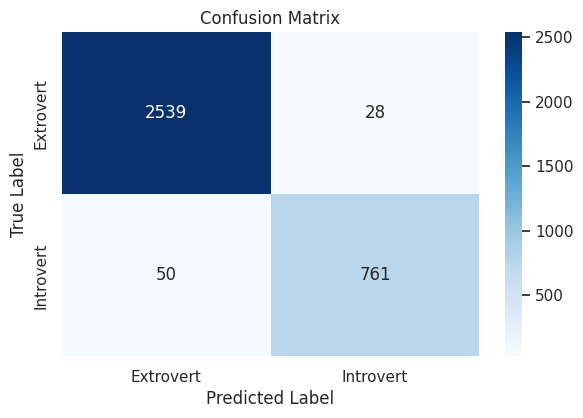



              precision    recall  f1-score   support

   Extrovert       0.98      0.99      0.98      2567
   Introvert       0.96      0.94      0.95       811

    accuracy                           0.98      3378
   macro avg       0.97      0.96      0.97      3378
weighted avg       0.98      0.98      0.98      3378



In [81]:
# We graph the confusion matrix

matrix_evaluator(
    lgbmc_result, 
    x_val, 
    y_val, 
    ["Extrovert", "Introvert"], 
    "Blues"
)

The results do not differ much from those previously obtained with the default parameters, but we managed to reduce the errors with a slight improvement in the model's ability to identify the labels.

In [82]:
# We define the final model

final_model = lgbmc_result

# We obtain the final parameters of the model

final_model.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 0.9,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': 4,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 200,
 'n_jobs': None,
 'num_leaves': 63,
 'objective': 'binary',
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'subsample': 0.8,
 'subsample_for_bin': 200000,
 'subsample_freq': 0,
 'force_col_wise': True,
 'verbose': -1}

We'll continue with the analysis of feature importance. To do so, we'll use shap values, which are based on solid game theory (Shapley values) that guarantee a fair distribution of the importance of each feature.

https://shap.readthedocs.io/en/latest/

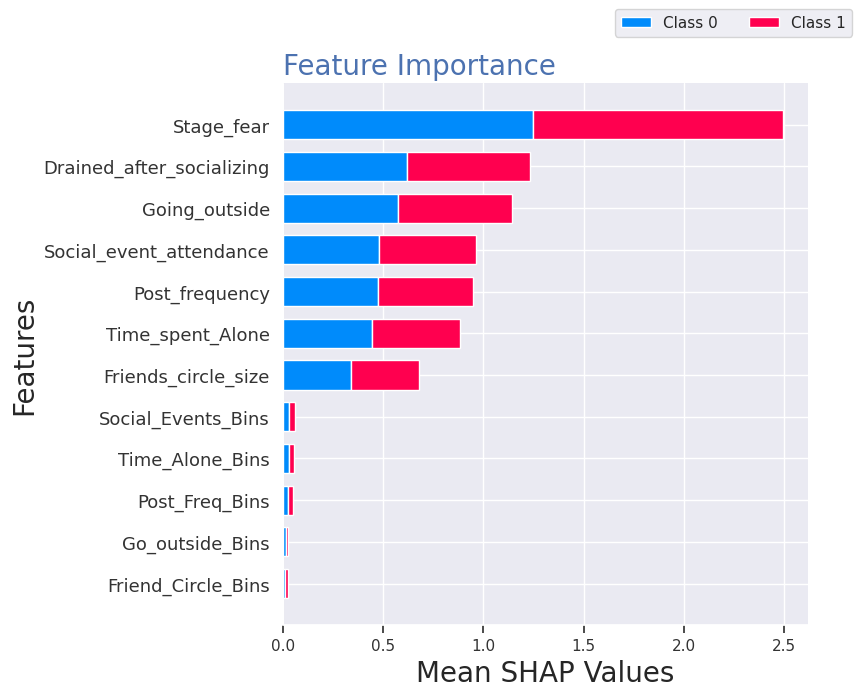

In [83]:
# We create an explainer for the best estimator

explainer = shap.Explainer(final_model)
shap_values = explainer.shap_values(x_val)

# we visualize the importance

fig = shap.summary_plot(
    shap_values,
    x_val,
    show=False
)

plt.legend(bbox_to_anchor=(1.1, 1.15), ncol=2)
plt.title("Feature Importance", fontsize=20, color="b", loc="left")
plt.xlabel("Mean SHAP Values", fontsize=20)
plt.ylabel("Features", fontsize=20)
plt.show()

We can observe that the original features completely dominate the model's predictions, with "Stage fear" being the most important variable by a large margin. This means the model has learned that this is the clearest signal for classifying personality. The model isn't basing its decisions on noise, but on the most logical and significant variables for the problem. The extremely low performance of all the features we created indicates that a more focused development on the relationships or transformations of the variables is a more appropriate approach, since the model is extremely good at creating its own groupings or cutoff points optimally. By having the original variables, the model learns that the "bin" versions are redundant and, therefore, assigns them an importance of zero. We could get rid of these variables, but we will continue to load and process the test data and perform our first submission to the competition.

# Test data

We will start by loading the test dataframe and performing an initial analysis to corroborate the data.

In [84]:
# We load the test data

df_test = pd.read_csv("/kaggle/input/playground-series-s5e7/test.csv")

In [85]:
# We check the shape and that no duplicate data is found

print(f"Length: {len(df_test.duplicated())}")
print(f"Duplicates: {df_test.duplicated().sum()}")
print(f"Shape: {df_test.shape}")

Length: 6175
Duplicates: 0
Shape: (6175, 8)


In [86]:
df_test.describe().T

,count,mean,std,min,25%,50%,75%,max
id,6175.0,21611.000000,1782.713288,18524.0,20067.5,21611.0,23154.5,24698.0
Time_spent_Alone,5750.0,3.116870,2.985658,0.0,1.0,2.0,4.0,11.0
Social_event_attendance,5778.0,5.287989,2.758052,0.0,3.0,5.0,8.0,10.0
Going_outside,5709.0,4.037835,2.045207,0.0,3.0,4.0,6.0,7.0
Friends_circle_size,5825.0,8.008412,4.192701,0.0,5.0,8.0,12.0,15.0
Post_frequency,5767.0,5.028958,2.867285,0.0,3.0,5.0,7.0,10.0


In [87]:
df_test.describe(exclude = np.number).T

,count,unique,top,freq
Stage_fear,5577,2,No,4236
Drained_after_socializing,5743,2,No,4437


In [88]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6175 entries, 0 to 6174
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         6175 non-null   int64  
 1   Time_spent_Alone           5750 non-null   float64
 2   Stage_fear                 5577 non-null   object 
 3   Social_event_attendance    5778 non-null   float64
 4   Going_outside              5709 non-null   float64
 5   Drained_after_socializing  5743 non-null   object 
 6   Friends_circle_size        5825 non-null   float64
 7   Post_frequency             5767 non-null   float64
dtypes: float64(5), int64(1), object(2)
memory usage: 386.1+ KB


We were able to confirm that we have the same features, in addition to observing missing values to handle.

## Data wrangling & Preprocessing

With the test data already loaded and verified, we will proceed with the corresponding data handling and preprocessing. We will apply the same methods and processes as with the train features. Once the preprocessing of the test data is complete, we will proceed to make the predictions.

In [89]:
# We start by removing the variables that we will not use

df_test_new = df_test.drop(columns="id")

In [90]:
# We confirm that there is no null values in test data

null_test = pd.DataFrame(
        {"Null Data" : df_test_new.isnull().sum(), 
         "Percentage" : (df_test_new.isnull().sum()) / (len(df_test_new)) * (100)})

null_test

,Null Data,Percentage
Time_spent_Alone,425,6.882591
Stage_fear,598,9.684211
Social_event_attendance,397,6.429150
Going_outside,466,7.546559
Drained_after_socializing,432,6.995951
Friends_circle_size,350,5.668016
Post_frequency,408,6.607287


In [91]:
# We use a for loop to complete the data

for column in df_test_new.columns:
    
    if df_test_new[column].isnull().sum() > 0:
        
        if pd.api.types.is_numeric_dtype(df_test_new[column]):
            imputed_value = df_test_new[column].mean().round(1)
        else:
            imputed_value = df_test_new[column].mode()[0]
        
        df_test_new[column].fillna(imputed_value, inplace=True)
        print(f"{column} : {df_test_new[column].isnull().sum()}")

Time_spent_Alone : 0
Stage_fear : 0
Social_event_attendance : 0
Going_outside : 0
Drained_after_socializing : 0
Friends_circle_size : 0
Post_frequency : 0


In [92]:
df_test_new.describe().T

,count,mean,std,min,25%,50%,75%,max
Time_spent_Alone,6175.0,3.115709,2.881067,0.0,1.0,3.0,4.0,11.0
Social_event_attendance,6175.0,5.288761,2.667907,0.0,3.0,5.3,7.0,10.0
Going_outside,6175.0,4.034980,1.966534,0.0,3.0,4.0,6.0,7.0
Friends_circle_size,6175.0,8.007935,4.072127,0.0,5.0,8.0,11.0,15.0
Post_frequency,6175.0,5.027045,2.770935,0.0,3.0,5.0,7.0,10.0


In [93]:
df_test_new.describe(exclude=np.number).T

,count,unique,top,freq
Stage_fear,6175,2,No,4834
Drained_after_socializing,6175,2,No,4869


In [94]:
df_test_new["Time_Alone_Bins"] = pd.cut(df_test_new["Time_spent_Alone"], bins_time_alone, labels=labels_personality)
df_test_new["Social_Events_Bins"] = pd.cut(df_test_new["Social_event_attendance"], bins_events, labels=labels_personality)
df_test_new["Go_outside_Bins"] = pd.cut(df_test_new["Going_outside"], bins_go_out, labels=labels_personality)
df_test_new["Friend_Circle_Bins"] = pd.cut(df_test_new["Friends_circle_size"], bins_friends, labels=labels_personality)
df_test_new["Post_Freq_Bins"] = pd.cut(df_test_new["Post_frequency"], bins_posts, labels=labels_personality)

In [95]:
df_test_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6175 entries, 0 to 6174
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   Time_spent_Alone           6175 non-null   float64 
 1   Stage_fear                 6175 non-null   object  
 2   Social_event_attendance    6175 non-null   float64 
 3   Going_outside              6175 non-null   float64 
 4   Drained_after_socializing  6175 non-null   object  
 5   Friends_circle_size        6175 non-null   float64 
 6   Post_frequency             6175 non-null   float64 
 7   Time_Alone_Bins            6175 non-null   category
 8   Social_Events_Bins         6175 non-null   category
 9   Go_outside_Bins            6175 non-null   category
 10  Friend_Circle_Bins         6175 non-null   category
 11  Post_Freq_Bins             6175 non-null   category
dtypes: category(5), float64(5), object(2)
memory usage: 368.6+ KB


In [96]:
# We apply OneHotEncoder

test_cat_cols = df_test_new[["Stage_fear", "Drained_after_socializing"]]
test_rest_cols = df_test_new.drop(columns=["Stage_fear", "Drained_after_socializing"])
test_cat_enc = encoder.transform(test_cat_cols)

# We changed the name of the encoded columns

test_cat_enc.rename(
    columns={"Stage_fear_Yes": "Stage_fear", 
             "Drained_after_socializing_Yes": "Drained_after_socializing"}, 
    inplace=True)

# We use a for loop to apply the function to the test bin columns

for column in test_rest_cols.columns:
    if isinstance(test_rest_cols[column].dtype, pd.CategoricalDtype):
        mapper(test_rest_cols, column, bins_order)

test_encoded = pd.concat([test_cat_enc, test_rest_cols], axis=1)

Time_Alone_Bins
2.0    2117
0.0    2042
1.0    2016
Name: count, dtype: int64
Social_Events_Bins
1.0    2410
2.0    2191
0.0    1574
Name: count, dtype: int64
Go_outside_Bins
1.0    2286
0.0    2254
2.0    1635
Name: count, dtype: int64
Friend_Circle_Bins
2.0    2348
0.0    1934
1.0    1893
Name: count, dtype: int64
Post_Freq_Bins
1.0    2149
2.0    2044
0.0    1982
Name: count, dtype: int64


In [97]:
test_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6175 entries, 0 to 6174
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Stage_fear                 6175 non-null   float64
 1   Drained_after_socializing  6175 non-null   float64
 2   Time_spent_Alone           6175 non-null   float64
 3   Social_event_attendance    6175 non-null   float64
 4   Going_outside              6175 non-null   float64
 5   Friends_circle_size        6175 non-null   float64
 6   Post_frequency             6175 non-null   float64
 7   Time_Alone_Bins            6175 non-null   float64
 8   Social_Events_Bins         6175 non-null   float64
 9   Go_outside_Bins            6175 non-null   float64
 10  Friend_Circle_Bins         6175 non-null   float64
 11  Post_Freq_Bins             6175 non-null   float64
dtypes: float64(12)
memory usage: 579.0 KB


In [98]:
# Variables to scale

test_numeric = test_encoded[[
    "Time_spent_Alone",
    "Social_event_attendance",
    "Going_outside",
    "Friends_circle_size",
    "Post_frequency"
]]

test_scale = scaler.transform(test_numeric)
test_rest = test_encoded.drop(columns=[
    "Time_spent_Alone",
    "Social_event_attendance",
    "Going_outside",
    "Friends_circle_size",
    "Post_frequency"
])

test_end = pd.concat([test_scale, test_rest], axis=1)

In [99]:
test_end.describe().T

,count,mean,std,min,25%,50%,75%,max
Time_spent_Alone,6175.0,0.371903,0.960356,-0.666667,-0.333333,0.333333,0.666667,3.000000
Social_event_attendance,6175.0,-0.177810,0.666977,-1.500000,-0.750000,-0.175000,0.250000,1.000000
Going_outside,6175.0,0.011660,0.655511,-1.333333,-0.333333,0.000000,0.666667,1.000000
Friends_circle_size,6175.0,0.001323,0.678688,-1.333333,-0.500000,0.000000,0.500000,1.166667
Post_frequency,6175.0,0.006761,0.692734,-1.250000,-0.500000,0.000000,0.500000,1.250000
Stage_fear,6175.0,0.217166,0.412350,0.000000,0.000000,0.000000,0.000000,1.000000
Drained_after_socializing,6175.0,0.211498,0.408404,0.000000,0.000000,0.000000,0.000000,1.000000
Time_Alone_Bins,6175.0,1.012146,0.820661,0.000000,0.000000,1.000000,2.000000,2.000000
Social_Events_Bins,6175.0,1.099919,0.774487,0.000000,0.000000,1.000000,2.000000,2.000000
Go_outside_Bins,6175.0,0.899757,0.787305,0.000000,0.000000,1.000000,2.000000,2.000000


In [100]:
test_end.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6175 entries, 0 to 6174
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Time_spent_Alone           6175 non-null   float64
 1   Social_event_attendance    6175 non-null   float64
 2   Going_outside              6175 non-null   float64
 3   Friends_circle_size        6175 non-null   float64
 4   Post_frequency             6175 non-null   float64
 5   Stage_fear                 6175 non-null   float64
 6   Drained_after_socializing  6175 non-null   float64
 7   Time_Alone_Bins            6175 non-null   float64
 8   Social_Events_Bins         6175 non-null   float64
 9   Go_outside_Bins            6175 non-null   float64
 10  Friend_Circle_Bins         6175 non-null   float64
 11  Post_Freq_Bins             6175 non-null   float64
dtypes: float64(12)
memory usage: 579.0 KB


We've finished applying the corresponding process to the test data. From this point, all that's left is to apply the model and make predictions.

## Apply the Model & Submission File

We will begin by making predictions with our model, and after corroborating the results with the sample data, we will proceed to make the submission file.

In [101]:
# We apply the trained model

personality_predictions = final_model.predict(test_end)

# Decode the predictions back to their original labels

decoded_predictions = le.inverse_transform(personality_predictions)

# We review the result

print("Total predictions: ", len(decoded_predictions), "\n")

Total predictions:  6175 



In [102]:
# We create the dataframe

personality_submission = pd.DataFrame({
    "id" : df_test["id"], 
    "Personality" : decoded_predictions
})

personality_submission.head()

,id,Personality
0,18524,Extrovert
1,18525,Introvert
2,18526,Extrovert
3,18527,Extrovert
4,18528,Introvert


In [103]:
# We load the submission sample data

personality_sample = pd.read_csv("/kaggle/input/playground-series-s5e7/sample_submission.csv")

In [104]:
# We compare the results with the sample

print(
    f"Shape Sample Submission: {personality_sample.shape}",
    f"\nShape Personality Submission: {personality_submission.shape}"
)
print("\n", personality_sample.head())

Shape Sample Submission: (6175, 2) 
Shape Personality Submission: (6175, 2)

     id   Personality
0  18524   Extrovert
1  18525   Extrovert
2  18526   Extrovert
3  18527   Extrovert
4  18528   Extrovert


In [105]:
# We convert the dataframe to a csv file

personality_submission.to_csv("submission.csv", index=False)

We've completed our first look at the competition. To conclude, I'll leave some notes or suggestions for next steps.

# Final Notes

- An important initial step, after the results obtained and evaluated, would be to return to feature engineering to implement a more robust and comprehensive process, focused on transformations and combinations of variables. The variables initially created are not necessary since the model handles groupings and end up contributing little.

- Return to data preprocessing and evaluate new tools, as well as different processes for handling missing data. It is important to find the most optimal method for this stage.

- Don't settle for the selected models, but rather test new variants or a different ensemble method to evaluate a larger number of models and find the optimal one for this problem.

- Once the model is selected, perform a broader and more comprehensive hyperparameter evaluation, in addition to applying a robust cross-validation method. Rely more on these results than on the LB scores.

I hope everything done throughout this notebook has been helpful to you. Good luck with everything!!